In [1]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier


print ('catboost version', cb.__version__)

catboost version 1.0.6


# K-Fold CV for Boosting Methods Using SKLearn 

In [2]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random
import statistics

In [3]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [5]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


In [6]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [7]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',
       'Rhythm', 'Subject'],
      dtype='object')


# CatBoosting

In [8]:
def confusion_calcs(confusion_matrix):
    temp_arr = confusion_matrix
    tn = temp_arr[0]
    fp = temp_arr[1]
    fn = temp_arr[2]
    tp = temp_arr[3]
    sensitivity = tp / (tp + fn)
    recall = sensitivity
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    accuracy = (tp+tn) / (tp+tn+fn+fp)
    f1 = 2*precision*recall/(precision+recall)
    return [accuracy, sensitivity, specificity, precision, f1]

In [9]:
from sklearn.metrics import roc_curve, auc

In [10]:
#Ignore the Rest of the STuff. Main One

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

model = CatBoostClassifier(learning_rate=0.1, iterations=100, depth=5, loss_function='Logloss', random_seed = 0)

#acc_score = [];
#Truth = [];
#Output = [];
iterations_list = []
#max_depth_list = []
#x_values = ['StoS']
# 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
#        'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
#        'AppEn', 'SampEn', 'IQR', 'Var', 'Rmean_Var', 'Mean_Absolute_Deviation'

y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf



all_features = ['AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility']
dataScores = [[],[],[],[],[],[],[],[],[],[]]
        
for score_idx,temp in tqdm(enumerate(all_features)):    
    
    x_values = [temp]
    print(x_values)

    acc_score = [];
    Truth = [];
    Output = [];



    for idx, subject in enumerate(good_list):

        train_index = ~df['Subject'].str.contains(subject)
        test_index = df['Subject'].str.contains(subject)
        X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
        y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()

        model.fit(X_train, y_train)

        # make the prediction using the resulting model
        pred_values = model.predict(X_test)
        #preds_proba = model.predict_proba(test_data)
        #print("class = ", preds_class)
        #print("proba = ", preds_proba)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values); ## it is a list  

        #print(model.feature_importances_)
    #     Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
    #                           index = (X_train.columns))
    #     Importance.sort_values(by = 'Importance', 
    #                        axis = 0, 
    #                        ascending = True).plot(kind = 'barh', 
    #                                               color = 'r')
    #     plt.xlabel('Variable Importance')
    #     plt.gca().legend_ = None
        #plt.savefig('plot1.png')


    elapsed = timeit.default_timer() - start_time #gives total computation time
    print("---Run time is %s seconds ---" % elapsed) #prints computation time
    print()

    print('Accuracy of each fold: \n {}'.format(acc_score))
    print()
    try: 
        print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
    except: 
        print('hi')
    print()
    print('Std of accuracy : \n{}'.format(np.std(acc_score)))
    print()
    print(confusion_matrix(Truth, Output))
    print()
    print(classification_report(Truth, Output))
    print()
    print(acc_score)
    print()
    print(elapsed)
    
    temp_array = confusion_matrix(Truth, Output)
    joint = temp_array[0].tolist() + temp_array[1].tolist()
    temp_scores = confusion_calcs(joint)
    
    #dataScores[score_idx].append(all_features[score_idx])
    #dataScores[score_idx].append(acc_score)
    dataScores[score_idx].append(np.mean(acc_score))
    dataScores[score_idx].append(np.std(acc_score))
    
    for confusionScore in temp_scores:
        dataScores[score_idx].append(confusionScore)

0it [00:00, ?it/s]

['AppEn']
0:	learn: 0.6261793	total: 149ms	remaining: 14.8s
1:	learn: 0.5712487	total: 152ms	remaining: 7.46s
2:	learn: 0.5257322	total: 155ms	remaining: 5.02s
3:	learn: 0.4872358	total: 158ms	remaining: 3.8s
4:	learn: 0.4544423	total: 161ms	remaining: 3.06s
5:	learn: 0.4263064	total: 164ms	remaining: 2.57s
6:	learn: 0.4020816	total: 167ms	remaining: 2.22s
7:	learn: 0.3812622	total: 170ms	remaining: 1.96s
8:	learn: 0.3633115	total: 173ms	remaining: 1.75s
9:	learn: 0.3475403	total: 176ms	remaining: 1.58s
10:	learn: 0.3338786	total: 179ms	remaining: 1.45s
11:	learn: 0.3216928	total: 182ms	remaining: 1.33s
12:	learn: 0.3109779	total: 185ms	remaining: 1.24s
13:	learn: 0.3019167	total: 188ms	remaining: 1.16s
14:	learn: 0.2936147	total: 191ms	remaining: 1.08s
15:	learn: 0.2862268	total: 194ms	remaining: 1.02s
16:	learn: 0.2797141	total: 197ms	remaining: 960ms
17:	learn: 0.2740216	total: 200ms	remaining: 910ms
18:	learn: 0.2689845	total: 203ms	remaining: 864ms
19:	learn: 0.2646640	total: 205m

61:	learn: 0.2339760	total: 186ms	remaining: 114ms
62:	learn: 0.2338139	total: 189ms	remaining: 111ms
63:	learn: 0.2336861	total: 192ms	remaining: 108ms
64:	learn: 0.2336142	total: 195ms	remaining: 105ms
65:	learn: 0.2335605	total: 198ms	remaining: 102ms
66:	learn: 0.2335158	total: 201ms	remaining: 99.2ms
67:	learn: 0.2334070	total: 205ms	remaining: 96.3ms
68:	learn: 0.2333776	total: 208ms	remaining: 93.4ms
69:	learn: 0.2333330	total: 211ms	remaining: 90.5ms
70:	learn: 0.2333062	total: 215ms	remaining: 87.6ms
71:	learn: 0.2332784	total: 218ms	remaining: 84.7ms
72:	learn: 0.2332652	total: 221ms	remaining: 81.7ms
73:	learn: 0.2332302	total: 224ms	remaining: 78.6ms
74:	learn: 0.2331948	total: 227ms	remaining: 75.6ms
75:	learn: 0.2331393	total: 230ms	remaining: 72.7ms
76:	learn: 0.2331262	total: 234ms	remaining: 69.8ms
77:	learn: 0.2330639	total: 236ms	remaining: 66.7ms
78:	learn: 0.2330481	total: 239ms	remaining: 63.6ms
79:	learn: 0.2330051	total: 242ms	remaining: 60.5ms
80:	learn: 0.2329

60:	learn: 0.2155673	total: 187ms	remaining: 120ms
61:	learn: 0.2154780	total: 190ms	remaining: 117ms
62:	learn: 0.2153815	total: 193ms	remaining: 113ms
63:	learn: 0.2153246	total: 196ms	remaining: 110ms
64:	learn: 0.2153002	total: 199ms	remaining: 107ms
65:	learn: 0.2152270	total: 203ms	remaining: 104ms
66:	learn: 0.2151629	total: 206ms	remaining: 101ms
67:	learn: 0.2151099	total: 209ms	remaining: 98.2ms
68:	learn: 0.2150710	total: 212ms	remaining: 95.3ms
69:	learn: 0.2150476	total: 216ms	remaining: 92.4ms
70:	learn: 0.2149937	total: 219ms	remaining: 89.4ms
71:	learn: 0.2149710	total: 222ms	remaining: 86.3ms
72:	learn: 0.2149191	total: 225ms	remaining: 83.2ms
73:	learn: 0.2148768	total: 228ms	remaining: 80.2ms
74:	learn: 0.2148612	total: 231ms	remaining: 77.1ms
75:	learn: 0.2147791	total: 235ms	remaining: 74.1ms
76:	learn: 0.2147586	total: 238ms	remaining: 71ms
77:	learn: 0.2146840	total: 240ms	remaining: 67.8ms
78:	learn: 0.2146643	total: 243ms	remaining: 64.7ms
79:	learn: 0.2146521	

62:	learn: 0.2337148	total: 187ms	remaining: 110ms
63:	learn: 0.2336355	total: 191ms	remaining: 107ms
64:	learn: 0.2335764	total: 193ms	remaining: 104ms
65:	learn: 0.2335313	total: 196ms	remaining: 101ms
66:	learn: 0.2334834	total: 199ms	remaining: 97.8ms
67:	learn: 0.2333806	total: 201ms	remaining: 94.8ms
68:	learn: 0.2333329	total: 204ms	remaining: 91.8ms
69:	learn: 0.2333037	total: 207ms	remaining: 88.7ms
70:	learn: 0.2332611	total: 210ms	remaining: 85.7ms
71:	learn: 0.2332331	total: 213ms	remaining: 82.8ms
72:	learn: 0.2332115	total: 216ms	remaining: 79.8ms
73:	learn: 0.2331947	total: 218ms	remaining: 76.7ms
74:	learn: 0.2331787	total: 221ms	remaining: 73.7ms
75:	learn: 0.2331256	total: 224ms	remaining: 70.7ms
76:	learn: 0.2331115	total: 227ms	remaining: 67.7ms
77:	learn: 0.2330530	total: 229ms	remaining: 64.7ms
78:	learn: 0.2330434	total: 232ms	remaining: 61.6ms
79:	learn: 0.2330120	total: 235ms	remaining: 58.6ms
80:	learn: 0.2329613	total: 237ms	remaining: 55.6ms
81:	learn: 0.232

68:	learn: 0.2357414	total: 199ms	remaining: 89.6ms
69:	learn: 0.2357184	total: 202ms	remaining: 86.7ms
70:	learn: 0.2356677	total: 205ms	remaining: 83.8ms
71:	learn: 0.2356399	total: 208ms	remaining: 80.9ms
72:	learn: 0.2356029	total: 211ms	remaining: 78.2ms
73:	learn: 0.2355643	total: 214ms	remaining: 75.3ms
74:	learn: 0.2355495	total: 217ms	remaining: 72.4ms
75:	learn: 0.2354943	total: 220ms	remaining: 69.5ms
76:	learn: 0.2354787	total: 223ms	remaining: 66.6ms
77:	learn: 0.2354214	total: 226ms	remaining: 63.7ms
78:	learn: 0.2354123	total: 229ms	remaining: 60.8ms
79:	learn: 0.2353764	total: 232ms	remaining: 57.9ms
80:	learn: 0.2353660	total: 235ms	remaining: 55ms
81:	learn: 0.2353403	total: 237ms	remaining: 52.1ms
82:	learn: 0.2352928	total: 240ms	remaining: 49.3ms
83:	learn: 0.2352810	total: 243ms	remaining: 46.3ms
84:	learn: 0.2351956	total: 246ms	remaining: 43.5ms
85:	learn: 0.2351096	total: 249ms	remaining: 40.6ms
86:	learn: 0.2350261	total: 252ms	remaining: 37.7ms
87:	learn: 0.2

68:	learn: 0.2281111	total: 196ms	remaining: 88ms
69:	learn: 0.2280253	total: 199ms	remaining: 85.2ms
70:	learn: 0.2279950	total: 202ms	remaining: 82.4ms
71:	learn: 0.2279673	total: 204ms	remaining: 79.5ms
72:	learn: 0.2279578	total: 208ms	remaining: 76.8ms
73:	learn: 0.2279427	total: 210ms	remaining: 73.9ms
74:	learn: 0.2279283	total: 213ms	remaining: 71.1ms
75:	learn: 0.2279182	total: 216ms	remaining: 68.2ms
76:	learn: 0.2279105	total: 219ms	remaining: 65.3ms
77:	learn: 0.2278647	total: 221ms	remaining: 62.4ms
78:	learn: 0.2278499	total: 224ms	remaining: 59.5ms
79:	learn: 0.2278335	total: 226ms	remaining: 56.6ms
80:	learn: 0.2278011	total: 229ms	remaining: 53.8ms
81:	learn: 0.2277081	total: 232ms	remaining: 50.9ms
82:	learn: 0.2276894	total: 234ms	remaining: 48ms
83:	learn: 0.2276743	total: 237ms	remaining: 45.2ms
84:	learn: 0.2275861	total: 240ms	remaining: 42.3ms
85:	learn: 0.2275666	total: 243ms	remaining: 39.5ms
86:	learn: 0.2275488	total: 245ms	remaining: 36.6ms
87:	learn: 0.227

77:	learn: 0.2328694	total: 224ms	remaining: 63.1ms
78:	learn: 0.2328550	total: 226ms	remaining: 60.2ms
79:	learn: 0.2327944	total: 229ms	remaining: 57.3ms
80:	learn: 0.2327856	total: 232ms	remaining: 54.4ms
81:	learn: 0.2327527	total: 235ms	remaining: 51.6ms
82:	learn: 0.2327219	total: 238ms	remaining: 48.8ms
83:	learn: 0.2327099	total: 241ms	remaining: 46ms
84:	learn: 0.2326826	total: 244ms	remaining: 43.1ms
85:	learn: 0.2326753	total: 247ms	remaining: 40.2ms
86:	learn: 0.2326535	total: 249ms	remaining: 37.3ms
87:	learn: 0.2326244	total: 252ms	remaining: 34.4ms
88:	learn: 0.2325785	total: 255ms	remaining: 31.5ms
89:	learn: 0.2325204	total: 258ms	remaining: 28.6ms
90:	learn: 0.2324980	total: 260ms	remaining: 25.8ms
91:	learn: 0.2324902	total: 263ms	remaining: 22.9ms
92:	learn: 0.2324421	total: 266ms	remaining: 20ms
93:	learn: 0.2324362	total: 269ms	remaining: 17.1ms
94:	learn: 0.2323746	total: 271ms	remaining: 14.3ms
95:	learn: 0.2323663	total: 274ms	remaining: 11.4ms
96:	learn: 0.232

73:	learn: 0.2364858	total: 210ms	remaining: 73.7ms
74:	learn: 0.2364619	total: 213ms	remaining: 70.9ms
75:	learn: 0.2364351	total: 216ms	remaining: 68.1ms
76:	learn: 0.2364078	total: 219ms	remaining: 65.3ms
77:	learn: 0.2363662	total: 222ms	remaining: 62.6ms
78:	learn: 0.2363579	total: 224ms	remaining: 59.7ms
79:	learn: 0.2363275	total: 227ms	remaining: 56.8ms
80:	learn: 0.2362545	total: 230ms	remaining: 54ms
81:	learn: 0.2362207	total: 233ms	remaining: 51.1ms
82:	learn: 0.2361966	total: 236ms	remaining: 48.3ms
83:	learn: 0.2361498	total: 238ms	remaining: 45.4ms
84:	learn: 0.2360969	total: 241ms	remaining: 42.6ms
85:	learn: 0.2360798	total: 244ms	remaining: 39.7ms
86:	learn: 0.2360247	total: 247ms	remaining: 36.9ms
87:	learn: 0.2360158	total: 249ms	remaining: 34ms
88:	learn: 0.2360127	total: 252ms	remaining: 31.1ms
89:	learn: 0.2359626	total: 255ms	remaining: 28.3ms
90:	learn: 0.2359523	total: 258ms	remaining: 25.5ms
91:	learn: 0.2359379	total: 260ms	remaining: 22.6ms
92:	learn: 0.235

81:	learn: 0.2263888	total: 230ms	remaining: 50.5ms
82:	learn: 0.2263636	total: 233ms	remaining: 47.7ms
83:	learn: 0.2263209	total: 236ms	remaining: 44.9ms
84:	learn: 0.2262960	total: 238ms	remaining: 42.1ms
85:	learn: 0.2262726	total: 241ms	remaining: 39.3ms
86:	learn: 0.2261946	total: 244ms	remaining: 36.5ms
87:	learn: 0.2261801	total: 247ms	remaining: 33.7ms
88:	learn: 0.2261751	total: 250ms	remaining: 30.8ms
89:	learn: 0.2261112	total: 252ms	remaining: 28ms
90:	learn: 0.2260633	total: 255ms	remaining: 25.2ms
91:	learn: 0.2260596	total: 258ms	remaining: 22.4ms
92:	learn: 0.2260165	total: 260ms	remaining: 19.6ms
93:	learn: 0.2260095	total: 263ms	remaining: 16.8ms
94:	learn: 0.2259880	total: 265ms	remaining: 14ms
95:	learn: 0.2259724	total: 268ms	remaining: 11.2ms
96:	learn: 0.2259650	total: 271ms	remaining: 8.37ms
97:	learn: 0.2259347	total: 274ms	remaining: 5.58ms
98:	learn: 0.2259106	total: 276ms	remaining: 2.79ms
99:	learn: 0.2258710	total: 279ms	remaining: 0us
0:	learn: 0.6267846

86:	learn: 0.2362612	total: 245ms	remaining: 36.5ms
87:	learn: 0.2362446	total: 247ms	remaining: 33.7ms
88:	learn: 0.2362212	total: 250ms	remaining: 30.9ms
89:	learn: 0.2361592	total: 253ms	remaining: 28.1ms
90:	learn: 0.2361429	total: 256ms	remaining: 25.3ms
91:	learn: 0.2361309	total: 259ms	remaining: 22.5ms
92:	learn: 0.2360957	total: 262ms	remaining: 19.7ms
93:	learn: 0.2360619	total: 264ms	remaining: 16.9ms
94:	learn: 0.2360516	total: 267ms	remaining: 14.1ms
95:	learn: 0.2360490	total: 270ms	remaining: 11.2ms
96:	learn: 0.2360443	total: 273ms	remaining: 8.43ms
97:	learn: 0.2360212	total: 275ms	remaining: 5.62ms
98:	learn: 0.2360008	total: 278ms	remaining: 2.81ms
99:	learn: 0.2359789	total: 281ms	remaining: 0us
0:	learn: 0.6234891	total: 3.56ms	remaining: 352ms
1:	learn: 0.5666401	total: 6.81ms	remaining: 334ms
2:	learn: 0.5195126	total: 9.88ms	remaining: 319ms
3:	learn: 0.4797642	total: 13.1ms	remaining: 315ms
4:	learn: 0.4459187	total: 16.3ms	remaining: 309ms
5:	learn: 0.4168613	

91:	learn: 0.2332492	total: 267ms	remaining: 23.2ms
92:	learn: 0.2332054	total: 270ms	remaining: 20.3ms
93:	learn: 0.2331907	total: 273ms	remaining: 17.4ms
94:	learn: 0.2331352	total: 276ms	remaining: 14.5ms
95:	learn: 0.2331197	total: 278ms	remaining: 11.6ms
96:	learn: 0.2331107	total: 282ms	remaining: 8.71ms
97:	learn: 0.2330343	total: 284ms	remaining: 5.8ms
98:	learn: 0.2329942	total: 287ms	remaining: 2.9ms
99:	learn: 0.2329663	total: 290ms	remaining: 0us
0:	learn: 0.6271636	total: 3.41ms	remaining: 337ms
1:	learn: 0.5730725	total: 6.62ms	remaining: 324ms
2:	learn: 0.5291300	total: 9.61ms	remaining: 311ms
3:	learn: 0.4912128	total: 12.9ms	remaining: 310ms
4:	learn: 0.4591573	total: 16ms	remaining: 304ms
5:	learn: 0.4315236	total: 19.1ms	remaining: 300ms
6:	learn: 0.4077360	total: 22.3ms	remaining: 297ms
7:	learn: 0.3871538	total: 25.3ms	remaining: 291ms
8:	learn: 0.3693309	total: 28.3ms	remaining: 287ms
9:	learn: 0.3539115	total: 31.3ms	remaining: 282ms
10:	learn: 0.3403077	total: 3

97:	learn: 0.2317196	total: 284ms	remaining: 5.79ms
98:	learn: 0.2316747	total: 287ms	remaining: 2.9ms
99:	learn: 0.2316511	total: 290ms	remaining: 0us
0:	learn: 0.6268727	total: 3.25ms	remaining: 322ms
1:	learn: 0.5727614	total: 6.31ms	remaining: 309ms
2:	learn: 0.5283032	total: 9.14ms	remaining: 296ms
3:	learn: 0.4902119	total: 12.2ms	remaining: 292ms
4:	learn: 0.4580061	total: 15.1ms	remaining: 286ms
5:	learn: 0.4302671	total: 18ms	remaining: 281ms
6:	learn: 0.4063593	total: 20.9ms	remaining: 278ms
7:	learn: 0.3857960	total: 24ms	remaining: 276ms
8:	learn: 0.3678238	total: 26.9ms	remaining: 272ms
9:	learn: 0.3521101	total: 29.8ms	remaining: 268ms
10:	learn: 0.3386111	total: 32.6ms	remaining: 264ms
11:	learn: 0.3265479	total: 35.7ms	remaining: 262ms
12:	learn: 0.3161909	total: 38.6ms	remaining: 258ms
13:	learn: 0.3070510	total: 41.5ms	remaining: 255ms
14:	learn: 0.2988481	total: 44.4ms	remaining: 252ms
15:	learn: 0.2916425	total: 47.2ms	remaining: 248ms
16:	learn: 0.2852215	total: 50

1it [00:08,  8.85s/it]

---Run time is 8.753738100000021 seconds ---

Accuracy of each fold: 
 [0.8850114416475973, 0.939553752535497, 0.9937027707808564, 0.6660671462829736, 0.9822361546499477, 0.9225152129817444, 0.8879028491359178, 0.9904697072838666, 0.928714859437751, 0.88257993384785, 0.9800362976406534, 0.9698492462311558, 0.7301587301587301, 1.0, 0.2980849292256453, 0.8334071776694727, 0.976010966415353, 0.9976918638199653, 0.6348267117497887, 0.9439252336448598, 0.9662104362703166, 0.935969868173258, 0.9416490486257928]

Avg accuracy : 
0.8820249712264778

Std of accuracy : 
0.15967882716215004

[[21673  3070]
 [ 2748 17477]]

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     24743
           1       0.85      0.86      0.86     20225

    accuracy                           0.87     44968
   macro avg       0.87      0.87      0.87     44968
weighted avg       0.87      0.87      0.87     44968


[0.8850114416475973, 0.939553752535497, 0.9937027707

70:	learn: 0.2348936	total: 209ms	remaining: 85.3ms
71:	learn: 0.2348664	total: 212ms	remaining: 82.4ms
72:	learn: 0.2347743	total: 215ms	remaining: 79.5ms
73:	learn: 0.2347529	total: 218ms	remaining: 76.6ms
74:	learn: 0.2347369	total: 221ms	remaining: 73.7ms
75:	learn: 0.2347079	total: 224ms	remaining: 70.7ms
76:	learn: 0.2346327	total: 227ms	remaining: 67.7ms
77:	learn: 0.2345841	total: 230ms	remaining: 64.8ms
78:	learn: 0.2345761	total: 233ms	remaining: 61.8ms
79:	learn: 0.2345585	total: 235ms	remaining: 58.9ms
80:	learn: 0.2345322	total: 238ms	remaining: 55.9ms
81:	learn: 0.2345281	total: 241ms	remaining: 52.9ms
82:	learn: 0.2344661	total: 244ms	remaining: 49.9ms
83:	learn: 0.2344530	total: 247ms	remaining: 47ms
84:	learn: 0.2344436	total: 249ms	remaining: 44ms
85:	learn: 0.2344364	total: 252ms	remaining: 41.1ms
86:	learn: 0.2343327	total: 255ms	remaining: 38.1ms
87:	learn: 0.2343144	total: 258ms	remaining: 35.2ms
88:	learn: 0.2342253	total: 261ms	remaining: 32.2ms
89:	learn: 0.234

69:	learn: 0.2159497	total: 210ms	remaining: 90.1ms
70:	learn: 0.2159153	total: 213ms	remaining: 87.1ms
71:	learn: 0.2159005	total: 216ms	remaining: 84.1ms
72:	learn: 0.2158882	total: 219ms	remaining: 81ms
73:	learn: 0.2157855	total: 222ms	remaining: 78.1ms
74:	learn: 0.2157001	total: 225ms	remaining: 75.1ms
75:	learn: 0.2156870	total: 228ms	remaining: 72.1ms
76:	learn: 0.2156693	total: 231ms	remaining: 69ms
77:	learn: 0.2156418	total: 234ms	remaining: 66ms
78:	learn: 0.2156324	total: 237ms	remaining: 62.9ms
79:	learn: 0.2155536	total: 239ms	remaining: 59.9ms
80:	learn: 0.2155493	total: 242ms	remaining: 56.8ms
81:	learn: 0.2155207	total: 245ms	remaining: 53.8ms
82:	learn: 0.2155065	total: 248ms	remaining: 50.8ms
83:	learn: 0.2154837	total: 251ms	remaining: 47.7ms
84:	learn: 0.2154589	total: 253ms	remaining: 44.7ms
85:	learn: 0.2154298	total: 256ms	remaining: 41.7ms
86:	learn: 0.2152840	total: 259ms	remaining: 38.7ms
87:	learn: 0.2152739	total: 262ms	remaining: 35.7ms
88:	learn: 0.21526

71:	learn: 0.2357735	total: 213ms	remaining: 82.6ms
72:	learn: 0.2357026	total: 215ms	remaining: 79.7ms
73:	learn: 0.2356830	total: 218ms	remaining: 76.7ms
74:	learn: 0.2356621	total: 221ms	remaining: 73.8ms
75:	learn: 0.2356438	total: 224ms	remaining: 70.7ms
76:	learn: 0.2356281	total: 227ms	remaining: 67.7ms
77:	learn: 0.2355872	total: 230ms	remaining: 64.8ms
78:	learn: 0.2355746	total: 233ms	remaining: 61.8ms
79:	learn: 0.2355638	total: 236ms	remaining: 58.9ms
80:	learn: 0.2355526	total: 239ms	remaining: 56ms
81:	learn: 0.2354945	total: 241ms	remaining: 53ms
82:	learn: 0.2354310	total: 244ms	remaining: 50ms
83:	learn: 0.2354200	total: 247ms	remaining: 47.1ms
84:	learn: 0.2354011	total: 250ms	remaining: 44.1ms
85:	learn: 0.2353935	total: 253ms	remaining: 41.2ms
86:	learn: 0.2352893	total: 256ms	remaining: 38.2ms
87:	learn: 0.2352815	total: 258ms	remaining: 35.2ms
88:	learn: 0.2351962	total: 261ms	remaining: 32.3ms
89:	learn: 0.2351850	total: 264ms	remaining: 29.4ms
90:	learn: 0.23516

75:	learn: 0.2367805	total: 220ms	remaining: 69.3ms
76:	learn: 0.2367771	total: 222ms	remaining: 66.5ms
77:	learn: 0.2367532	total: 225ms	remaining: 63.6ms
78:	learn: 0.2367415	total: 228ms	remaining: 60.6ms
79:	learn: 0.2367274	total: 231ms	remaining: 57.8ms
80:	learn: 0.2366968	total: 234ms	remaining: 54.8ms
81:	learn: 0.2366678	total: 237ms	remaining: 52ms
82:	learn: 0.2365949	total: 240ms	remaining: 49.1ms
83:	learn: 0.2365759	total: 242ms	remaining: 46.2ms
84:	learn: 0.2365113	total: 245ms	remaining: 43.3ms
85:	learn: 0.2364978	total: 248ms	remaining: 40.4ms
86:	learn: 0.2364233	total: 251ms	remaining: 37.5ms
87:	learn: 0.2364112	total: 254ms	remaining: 34.6ms
88:	learn: 0.2363659	total: 257ms	remaining: 31.7ms
89:	learn: 0.2363335	total: 260ms	remaining: 28.8ms
90:	learn: 0.2362723	total: 262ms	remaining: 25.9ms
91:	learn: 0.2362521	total: 265ms	remaining: 23.1ms
92:	learn: 0.2362359	total: 268ms	remaining: 20.2ms
93:	learn: 0.2362357	total: 271ms	remaining: 17.3ms
94:	learn: 0.2

71:	learn: 0.2273861	total: 221ms	remaining: 85.9ms
72:	learn: 0.2273763	total: 224ms	remaining: 82.8ms
73:	learn: 0.2273585	total: 227ms	remaining: 79.8ms
74:	learn: 0.2273435	total: 230ms	remaining: 76.7ms
75:	learn: 0.2273412	total: 234ms	remaining: 73.8ms
76:	learn: 0.2273336	total: 237ms	remaining: 70.8ms
77:	learn: 0.2273190	total: 240ms	remaining: 67.7ms
78:	learn: 0.2273089	total: 244ms	remaining: 64.7ms
79:	learn: 0.2273019	total: 247ms	remaining: 61.7ms
80:	learn: 0.2272984	total: 251ms	remaining: 58.8ms
81:	learn: 0.2272823	total: 254ms	remaining: 55.8ms
82:	learn: 0.2272670	total: 258ms	remaining: 52.8ms
83:	learn: 0.2272480	total: 261ms	remaining: 49.8ms
84:	learn: 0.2272364	total: 265ms	remaining: 46.8ms
85:	learn: 0.2272228	total: 270ms	remaining: 43.9ms
86:	learn: 0.2271510	total: 274ms	remaining: 41ms
87:	learn: 0.2271417	total: 278ms	remaining: 37.9ms
88:	learn: 0.2271318	total: 282ms	remaining: 34.8ms
89:	learn: 0.2270741	total: 286ms	remaining: 31.7ms
90:	learn: 0.2

57:	learn: 0.2359310	total: 179ms	remaining: 129ms
58:	learn: 0.2358004	total: 182ms	remaining: 126ms
59:	learn: 0.2357764	total: 185ms	remaining: 123ms
60:	learn: 0.2357175	total: 188ms	remaining: 120ms
61:	learn: 0.2355689	total: 191ms	remaining: 117ms
62:	learn: 0.2355141	total: 194ms	remaining: 114ms
63:	learn: 0.2353885	total: 197ms	remaining: 111ms
64:	learn: 0.2353313	total: 200ms	remaining: 108ms
65:	learn: 0.2352708	total: 203ms	remaining: 105ms
66:	learn: 0.2352357	total: 206ms	remaining: 102ms
67:	learn: 0.2351708	total: 209ms	remaining: 98.4ms
68:	learn: 0.2351437	total: 212ms	remaining: 95.3ms
69:	learn: 0.2351122	total: 215ms	remaining: 92.2ms
70:	learn: 0.2350790	total: 218ms	remaining: 89.1ms
71:	learn: 0.2350697	total: 221ms	remaining: 86ms
72:	learn: 0.2350569	total: 224ms	remaining: 82.8ms
73:	learn: 0.2349642	total: 227ms	remaining: 79.7ms
74:	learn: 0.2349367	total: 230ms	remaining: 76.7ms
75:	learn: 0.2349281	total: 233ms	remaining: 73.6ms
76:	learn: 0.2349082	tot

60:	learn: 0.2384364	total: 188ms	remaining: 120ms
61:	learn: 0.2384154	total: 191ms	remaining: 117ms
62:	learn: 0.2383784	total: 194ms	remaining: 114ms
63:	learn: 0.2383597	total: 197ms	remaining: 111ms
64:	learn: 0.2383149	total: 200ms	remaining: 108ms
65:	learn: 0.2382352	total: 203ms	remaining: 105ms
66:	learn: 0.2381823	total: 206ms	remaining: 102ms
67:	learn: 0.2381303	total: 209ms	remaining: 98.5ms
68:	learn: 0.2380059	total: 212ms	remaining: 95.4ms
69:	learn: 0.2379775	total: 216ms	remaining: 92.4ms
70:	learn: 0.2379410	total: 218ms	remaining: 89.2ms
71:	learn: 0.2379095	total: 221ms	remaining: 86.1ms
72:	learn: 0.2378433	total: 224ms	remaining: 82.9ms
73:	learn: 0.2378294	total: 227ms	remaining: 79.8ms
74:	learn: 0.2377338	total: 230ms	remaining: 76.7ms
75:	learn: 0.2377230	total: 233ms	remaining: 73.6ms
76:	learn: 0.2376454	total: 236ms	remaining: 70.5ms
77:	learn: 0.2375734	total: 239ms	remaining: 67.4ms
78:	learn: 0.2375622	total: 242ms	remaining: 64.3ms
79:	learn: 0.237544

59:	learn: 0.2288418	total: 180ms	remaining: 120ms
60:	learn: 0.2287852	total: 183ms	remaining: 117ms
61:	learn: 0.2287155	total: 186ms	remaining: 114ms
62:	learn: 0.2286938	total: 188ms	remaining: 110ms
63:	learn: 0.2286591	total: 191ms	remaining: 107ms
64:	learn: 0.2286489	total: 194ms	remaining: 105ms
65:	learn: 0.2286375	total: 197ms	remaining: 101ms
66:	learn: 0.2286052	total: 200ms	remaining: 98.3ms
67:	learn: 0.2284939	total: 202ms	remaining: 95.3ms
68:	learn: 0.2284415	total: 205ms	remaining: 92.1ms
69:	learn: 0.2284024	total: 208ms	remaining: 89ms
70:	learn: 0.2282922	total: 211ms	remaining: 86ms
71:	learn: 0.2281913	total: 213ms	remaining: 83ms
72:	learn: 0.2281598	total: 216ms	remaining: 80ms
73:	learn: 0.2281101	total: 219ms	remaining: 76.9ms
74:	learn: 0.2280241	total: 222ms	remaining: 73.9ms
75:	learn: 0.2280081	total: 224ms	remaining: 70.9ms
76:	learn: 0.2279773	total: 227ms	remaining: 67.9ms
77:	learn: 0.2279653	total: 230ms	remaining: 64.9ms
78:	learn: 0.2279053	total:

56:	learn: 0.2393155	total: 180ms	remaining: 135ms
57:	learn: 0.2392391	total: 183ms	remaining: 133ms
58:	learn: 0.2392121	total: 186ms	remaining: 130ms
59:	learn: 0.2392037	total: 190ms	remaining: 126ms
60:	learn: 0.2391497	total: 193ms	remaining: 123ms
61:	learn: 0.2390140	total: 196ms	remaining: 120ms
62:	learn: 0.2389654	total: 200ms	remaining: 117ms
63:	learn: 0.2389440	total: 203ms	remaining: 114ms
64:	learn: 0.2388919	total: 206ms	remaining: 111ms
65:	learn: 0.2388442	total: 209ms	remaining: 108ms
66:	learn: 0.2388139	total: 212ms	remaining: 105ms
67:	learn: 0.2387499	total: 216ms	remaining: 101ms
68:	learn: 0.2386324	total: 219ms	remaining: 98.3ms
69:	learn: 0.2385977	total: 222ms	remaining: 95.2ms
70:	learn: 0.2385430	total: 225ms	remaining: 92ms
71:	learn: 0.2385156	total: 228ms	remaining: 88.8ms
72:	learn: 0.2384859	total: 231ms	remaining: 85.5ms
73:	learn: 0.2384130	total: 234ms	remaining: 82.3ms
74:	learn: 0.2384021	total: 238ms	remaining: 79.2ms
75:	learn: 0.2383983	total

64:	learn: 0.2349737	total: 192ms	remaining: 103ms
65:	learn: 0.2349538	total: 195ms	remaining: 100ms
66:	learn: 0.2348636	total: 197ms	remaining: 97.2ms
67:	learn: 0.2347831	total: 200ms	remaining: 94.3ms
68:	learn: 0.2347196	total: 204ms	remaining: 91.4ms
69:	learn: 0.2346892	total: 206ms	remaining: 88.5ms
70:	learn: 0.2346495	total: 209ms	remaining: 85.4ms
71:	learn: 0.2346144	total: 212ms	remaining: 82.4ms
72:	learn: 0.2346004	total: 215ms	remaining: 79.4ms
73:	learn: 0.2345267	total: 218ms	remaining: 76.4ms
74:	learn: 0.2344944	total: 220ms	remaining: 73.5ms
75:	learn: 0.2344683	total: 223ms	remaining: 70.5ms
76:	learn: 0.2344502	total: 226ms	remaining: 67.5ms
77:	learn: 0.2344323	total: 229ms	remaining: 64.6ms
78:	learn: 0.2344239	total: 232ms	remaining: 61.7ms
79:	learn: 0.2343610	total: 235ms	remaining: 58.7ms
80:	learn: 0.2343535	total: 238ms	remaining: 55.7ms
81:	learn: 0.2343287	total: 240ms	remaining: 52.8ms
82:	learn: 0.2343223	total: 243ms	remaining: 49.9ms
83:	learn: 0.2

68:	learn: 0.2331627	total: 200ms	remaining: 90ms
69:	learn: 0.2331212	total: 203ms	remaining: 87.1ms
70:	learn: 0.2330894	total: 206ms	remaining: 84.2ms
71:	learn: 0.2330212	total: 209ms	remaining: 81.2ms
72:	learn: 0.2330131	total: 212ms	remaining: 78.3ms
73:	learn: 0.2329319	total: 214ms	remaining: 75.3ms
74:	learn: 0.2328660	total: 217ms	remaining: 72.4ms
75:	learn: 0.2328014	total: 220ms	remaining: 69.6ms
76:	learn: 0.2327846	total: 224ms	remaining: 66.8ms
77:	learn: 0.2327657	total: 227ms	remaining: 64ms
78:	learn: 0.2327426	total: 229ms	remaining: 61ms
79:	learn: 0.2327220	total: 232ms	remaining: 58ms
80:	learn: 0.2327092	total: 235ms	remaining: 55.1ms
81:	learn: 0.2326741	total: 238ms	remaining: 52.2ms
82:	learn: 0.2326596	total: 241ms	remaining: 49.3ms
83:	learn: 0.2326388	total: 243ms	remaining: 46.4ms
84:	learn: 0.2326316	total: 246ms	remaining: 43.4ms
85:	learn: 0.2326294	total: 249ms	remaining: 40.5ms
86:	learn: 0.2325900	total: 252ms	remaining: 37.6ms
87:	learn: 0.2325719

2it [00:17,  8.83s/it]

71:	learn: 0.2349922	total: 206ms	remaining: 80ms
72:	learn: 0.2349026	total: 209ms	remaining: 77.2ms
73:	learn: 0.2348848	total: 211ms	remaining: 74.3ms
74:	learn: 0.2348414	total: 215ms	remaining: 71.6ms
75:	learn: 0.2348381	total: 217ms	remaining: 68.6ms
76:	learn: 0.2348151	total: 220ms	remaining: 65.7ms
77:	learn: 0.2347715	total: 223ms	remaining: 62.8ms
78:	learn: 0.2347096	total: 226ms	remaining: 60ms
79:	learn: 0.2346978	total: 228ms	remaining: 57.1ms
80:	learn: 0.2346731	total: 231ms	remaining: 54.2ms
81:	learn: 0.2346506	total: 234ms	remaining: 51.3ms
82:	learn: 0.2346221	total: 236ms	remaining: 48.4ms
83:	learn: 0.2346056	total: 239ms	remaining: 45.6ms
84:	learn: 0.2345447	total: 242ms	remaining: 42.7ms
85:	learn: 0.2345208	total: 245ms	remaining: 39.8ms
86:	learn: 0.2345024	total: 247ms	remaining: 37ms
87:	learn: 0.2344408	total: 250ms	remaining: 34.1ms
88:	learn: 0.2344208	total: 253ms	remaining: 31.3ms
89:	learn: 0.2343867	total: 256ms	remaining: 28.4ms
90:	learn: 0.23437

63:	learn: 0.2353088	total: 182ms	remaining: 103ms
64:	learn: 0.2352517	total: 185ms	remaining: 99.7ms
65:	learn: 0.2351922	total: 188ms	remaining: 96.9ms
66:	learn: 0.2351671	total: 191ms	remaining: 94ms
67:	learn: 0.2351385	total: 194ms	remaining: 91.2ms
68:	learn: 0.2350960	total: 197ms	remaining: 88.4ms
69:	learn: 0.2350036	total: 200ms	remaining: 85.5ms
70:	learn: 0.2348936	total: 202ms	remaining: 82.7ms
71:	learn: 0.2348664	total: 205ms	remaining: 79.9ms
72:	learn: 0.2347743	total: 208ms	remaining: 77ms
73:	learn: 0.2347529	total: 211ms	remaining: 74.1ms
74:	learn: 0.2347369	total: 214ms	remaining: 71.3ms
75:	learn: 0.2347079	total: 216ms	remaining: 68.3ms
76:	learn: 0.2346327	total: 219ms	remaining: 65.4ms
77:	learn: 0.2345841	total: 222ms	remaining: 62.5ms
78:	learn: 0.2345761	total: 225ms	remaining: 59.7ms
79:	learn: 0.2345585	total: 227ms	remaining: 56.8ms
80:	learn: 0.2345322	total: 230ms	remaining: 53.9ms
81:	learn: 0.2345281	total: 232ms	remaining: 51ms
82:	learn: 0.234466

61:	learn: 0.2163671	total: 180ms	remaining: 110ms
62:	learn: 0.2162918	total: 183ms	remaining: 107ms
63:	learn: 0.2162431	total: 186ms	remaining: 105ms
64:	learn: 0.2161546	total: 189ms	remaining: 102ms
65:	learn: 0.2161324	total: 194ms	remaining: 100ms
66:	learn: 0.2160910	total: 197ms	remaining: 97.2ms
67:	learn: 0.2160217	total: 201ms	remaining: 94.5ms
68:	learn: 0.2159882	total: 204ms	remaining: 91.6ms
69:	learn: 0.2159497	total: 207ms	remaining: 88.7ms
70:	learn: 0.2159153	total: 210ms	remaining: 85.7ms
71:	learn: 0.2159005	total: 213ms	remaining: 82.7ms
72:	learn: 0.2158882	total: 215ms	remaining: 79.6ms
73:	learn: 0.2157855	total: 218ms	remaining: 76.7ms
74:	learn: 0.2157001	total: 222ms	remaining: 73.9ms
75:	learn: 0.2156870	total: 225ms	remaining: 70.9ms
76:	learn: 0.2156693	total: 228ms	remaining: 68ms
77:	learn: 0.2156418	total: 230ms	remaining: 65ms
78:	learn: 0.2156324	total: 233ms	remaining: 62ms
79:	learn: 0.2155536	total: 236ms	remaining: 59.1ms
80:	learn: 0.2155493	to

60:	learn: 0.2362354	total: 180ms	remaining: 115ms
61:	learn: 0.2362175	total: 183ms	remaining: 112ms
62:	learn: 0.2361814	total: 186ms	remaining: 109ms
63:	learn: 0.2360976	total: 188ms	remaining: 106ms
64:	learn: 0.2360671	total: 191ms	remaining: 103ms
65:	learn: 0.2360109	total: 194ms	remaining: 100ms
66:	learn: 0.2359859	total: 197ms	remaining: 97ms
67:	learn: 0.2359688	total: 200ms	remaining: 94.2ms
68:	learn: 0.2359396	total: 203ms	remaining: 91.2ms
69:	learn: 0.2358458	total: 206ms	remaining: 88.2ms
70:	learn: 0.2358031	total: 209ms	remaining: 85.2ms
71:	learn: 0.2357735	total: 211ms	remaining: 82.2ms
72:	learn: 0.2357026	total: 214ms	remaining: 79.2ms
73:	learn: 0.2356830	total: 217ms	remaining: 76.2ms
74:	learn: 0.2356621	total: 220ms	remaining: 73.3ms
75:	learn: 0.2356438	total: 223ms	remaining: 70.3ms
76:	learn: 0.2356281	total: 225ms	remaining: 67.3ms
77:	learn: 0.2355872	total: 228ms	remaining: 64.4ms
78:	learn: 0.2355746	total: 231ms	remaining: 61.4ms
79:	learn: 0.2355638

65:	learn: 0.2373322	total: 193ms	remaining: 99.5ms
66:	learn: 0.2372366	total: 196ms	remaining: 96.5ms
67:	learn: 0.2371555	total: 199ms	remaining: 93.5ms
68:	learn: 0.2371027	total: 202ms	remaining: 90.6ms
69:	learn: 0.2370713	total: 205ms	remaining: 87.7ms
70:	learn: 0.2370461	total: 208ms	remaining: 84.8ms
71:	learn: 0.2369462	total: 210ms	remaining: 81.8ms
72:	learn: 0.2369376	total: 213ms	remaining: 78.9ms
73:	learn: 0.2368801	total: 217ms	remaining: 76.1ms
74:	learn: 0.2367895	total: 220ms	remaining: 73.3ms
75:	learn: 0.2367805	total: 222ms	remaining: 70.2ms
76:	learn: 0.2367771	total: 225ms	remaining: 67.3ms
77:	learn: 0.2367532	total: 228ms	remaining: 64.4ms
78:	learn: 0.2367415	total: 231ms	remaining: 61.4ms
79:	learn: 0.2367274	total: 234ms	remaining: 58.5ms
80:	learn: 0.2366968	total: 237ms	remaining: 55.5ms
81:	learn: 0.2366678	total: 239ms	remaining: 52.5ms
82:	learn: 0.2365949	total: 242ms	remaining: 49.6ms
83:	learn: 0.2365759	total: 245ms	remaining: 46.6ms
84:	learn: 0

69:	learn: 0.2274259	total: 204ms	remaining: 87.6ms
70:	learn: 0.2273912	total: 207ms	remaining: 84.7ms
71:	learn: 0.2273861	total: 210ms	remaining: 81.7ms
72:	learn: 0.2273763	total: 213ms	remaining: 78.7ms
73:	learn: 0.2273585	total: 216ms	remaining: 75.8ms
74:	learn: 0.2273435	total: 219ms	remaining: 73ms
75:	learn: 0.2273412	total: 222ms	remaining: 70.1ms
76:	learn: 0.2273336	total: 225ms	remaining: 67.1ms
77:	learn: 0.2273190	total: 227ms	remaining: 64.1ms
78:	learn: 0.2273089	total: 230ms	remaining: 61.2ms
79:	learn: 0.2273019	total: 233ms	remaining: 58.3ms
80:	learn: 0.2272984	total: 236ms	remaining: 55.4ms
81:	learn: 0.2272823	total: 239ms	remaining: 52.4ms
82:	learn: 0.2272670	total: 242ms	remaining: 49.5ms
83:	learn: 0.2272480	total: 244ms	remaining: 46.5ms
84:	learn: 0.2272364	total: 247ms	remaining: 43.6ms
85:	learn: 0.2272228	total: 250ms	remaining: 40.7ms
86:	learn: 0.2271510	total: 253ms	remaining: 37.8ms
87:	learn: 0.2271417	total: 256ms	remaining: 34.9ms
88:	learn: 0.2

74:	learn: 0.2349367	total: 217ms	remaining: 72.2ms
75:	learn: 0.2349281	total: 220ms	remaining: 69.4ms
76:	learn: 0.2349082	total: 223ms	remaining: 66.5ms
77:	learn: 0.2348774	total: 225ms	remaining: 63.6ms
78:	learn: 0.2348657	total: 228ms	remaining: 60.7ms
79:	learn: 0.2348388	total: 231ms	remaining: 57.9ms
80:	learn: 0.2348377	total: 234ms	remaining: 54.9ms
81:	learn: 0.2348054	total: 237ms	remaining: 52ms
82:	learn: 0.2347955	total: 240ms	remaining: 49.1ms
83:	learn: 0.2347497	total: 243ms	remaining: 46.2ms
84:	learn: 0.2346743	total: 245ms	remaining: 43.3ms
85:	learn: 0.2346619	total: 248ms	remaining: 40.4ms
86:	learn: 0.2346294	total: 251ms	remaining: 37.5ms
87:	learn: 0.2346157	total: 254ms	remaining: 34.6ms
88:	learn: 0.2345580	total: 256ms	remaining: 31.7ms
89:	learn: 0.2345351	total: 259ms	remaining: 28.8ms
90:	learn: 0.2345289	total: 262ms	remaining: 25.9ms
91:	learn: 0.2344970	total: 265ms	remaining: 23ms
92:	learn: 0.2344154	total: 268ms	remaining: 20.1ms
93:	learn: 0.234

78:	learn: 0.2375622	total: 230ms	remaining: 61.2ms
79:	learn: 0.2375444	total: 233ms	remaining: 58.3ms
80:	learn: 0.2375251	total: 236ms	remaining: 55.3ms
81:	learn: 0.2374763	total: 239ms	remaining: 52.4ms
82:	learn: 0.2374209	total: 242ms	remaining: 49.5ms
83:	learn: 0.2374011	total: 245ms	remaining: 46.6ms
84:	learn: 0.2373747	total: 247ms	remaining: 43.7ms
85:	learn: 0.2373582	total: 250ms	remaining: 40.7ms
86:	learn: 0.2373348	total: 253ms	remaining: 37.8ms
87:	learn: 0.2372887	total: 256ms	remaining: 34.9ms
88:	learn: 0.2372735	total: 258ms	remaining: 31.9ms
89:	learn: 0.2372540	total: 261ms	remaining: 29ms
90:	learn: 0.2372439	total: 264ms	remaining: 26.1ms
91:	learn: 0.2372342	total: 267ms	remaining: 23.2ms
92:	learn: 0.2372097	total: 270ms	remaining: 20.3ms
93:	learn: 0.2371996	total: 272ms	remaining: 17.4ms
94:	learn: 0.2371520	total: 275ms	remaining: 14.5ms
95:	learn: 0.2371486	total: 278ms	remaining: 11.6ms
96:	learn: 0.2371467	total: 281ms	remaining: 8.68ms
97:	learn: 0.2

82:	learn: 0.2277575	total: 238ms	remaining: 48.8ms
83:	learn: 0.2277335	total: 241ms	remaining: 45.9ms
84:	learn: 0.2276930	total: 244ms	remaining: 43ms
85:	learn: 0.2276400	total: 247ms	remaining: 40.2ms
86:	learn: 0.2275583	total: 250ms	remaining: 37.3ms
87:	learn: 0.2275320	total: 253ms	remaining: 34.5ms
88:	learn: 0.2274664	total: 256ms	remaining: 31.6ms
89:	learn: 0.2274092	total: 259ms	remaining: 28.8ms
90:	learn: 0.2273923	total: 262ms	remaining: 25.9ms
91:	learn: 0.2273435	total: 265ms	remaining: 23ms
92:	learn: 0.2273170	total: 268ms	remaining: 20.1ms
93:	learn: 0.2272920	total: 271ms	remaining: 17.3ms
94:	learn: 0.2272754	total: 273ms	remaining: 14.4ms
95:	learn: 0.2272644	total: 276ms	remaining: 11.5ms
96:	learn: 0.2272421	total: 279ms	remaining: 8.62ms
97:	learn: 0.2272256	total: 281ms	remaining: 5.74ms
98:	learn: 0.2272003	total: 284ms	remaining: 2.87ms
99:	learn: 0.2271928	total: 287ms	remaining: 0us
0:	learn: 0.6267557	total: 3.79ms	remaining: 376ms
1:	learn: 0.5724666	

83:	learn: 0.2381495	total: 240ms	remaining: 45.7ms
84:	learn: 0.2380927	total: 243ms	remaining: 42.8ms
85:	learn: 0.2380763	total: 246ms	remaining: 40ms
86:	learn: 0.2380577	total: 248ms	remaining: 37.1ms
87:	learn: 0.2380082	total: 251ms	remaining: 34.3ms
88:	learn: 0.2380026	total: 254ms	remaining: 31.4ms
89:	learn: 0.2379872	total: 257ms	remaining: 28.5ms
90:	learn: 0.2379690	total: 260ms	remaining: 25.7ms
91:	learn: 0.2379644	total: 263ms	remaining: 22.9ms
92:	learn: 0.2379478	total: 266ms	remaining: 20ms
93:	learn: 0.2379377	total: 269ms	remaining: 17.2ms
94:	learn: 0.2379314	total: 272ms	remaining: 14.3ms
95:	learn: 0.2379276	total: 274ms	remaining: 11.4ms
96:	learn: 0.2379247	total: 277ms	remaining: 8.57ms
97:	learn: 0.2378963	total: 280ms	remaining: 5.71ms
98:	learn: 0.2378797	total: 283ms	remaining: 2.86ms
99:	learn: 0.2378476	total: 286ms	remaining: 0us
0:	learn: 0.6225363	total: 3.78ms	remaining: 374ms
1:	learn: 0.5650135	total: 7.16ms	remaining: 351ms
2:	learn: 0.5174330	t

85:	learn: 0.2342867	total: 250ms	remaining: 40.6ms
86:	learn: 0.2342531	total: 252ms	remaining: 37.7ms
87:	learn: 0.2342471	total: 255ms	remaining: 34.8ms
88:	learn: 0.2342221	total: 258ms	remaining: 31.9ms
89:	learn: 0.2342020	total: 261ms	remaining: 29ms
90:	learn: 0.2341813	total: 264ms	remaining: 26.1ms
91:	learn: 0.2341591	total: 267ms	remaining: 23.2ms
92:	learn: 0.2341456	total: 270ms	remaining: 20.3ms
93:	learn: 0.2341430	total: 272ms	remaining: 17.4ms
94:	learn: 0.2341351	total: 275ms	remaining: 14.5ms
95:	learn: 0.2341288	total: 278ms	remaining: 11.6ms
96:	learn: 0.2341089	total: 281ms	remaining: 8.7ms
97:	learn: 0.2340829	total: 284ms	remaining: 5.8ms
98:	learn: 0.2340412	total: 287ms	remaining: 2.9ms
99:	learn: 0.2340061	total: 290ms	remaining: 0us
0:	learn: 0.6267100	total: 3.57ms	remaining: 353ms
1:	learn: 0.5724863	total: 6.73ms	remaining: 330ms
2:	learn: 0.5273973	total: 9.9ms	remaining: 320ms
3:	learn: 0.4894632	total: 13.2ms	remaining: 317ms
4:	learn: 0.4577125	total

86:	learn: 0.2325900	total: 255ms	remaining: 38.2ms
87:	learn: 0.2325719	total: 258ms	remaining: 35.2ms
88:	learn: 0.2325700	total: 261ms	remaining: 32.3ms
89:	learn: 0.2325349	total: 264ms	remaining: 29.4ms
90:	learn: 0.2324920	total: 267ms	remaining: 26.4ms
91:	learn: 0.2324912	total: 270ms	remaining: 23.5ms
92:	learn: 0.2324191	total: 273ms	remaining: 20.5ms
93:	learn: 0.2324184	total: 275ms	remaining: 17.6ms
94:	learn: 0.2323694	total: 279ms	remaining: 14.7ms
95:	learn: 0.2323554	total: 282ms	remaining: 11.7ms
96:	learn: 0.2323379	total: 285ms	remaining: 8.8ms
97:	learn: 0.2322874	total: 287ms	remaining: 5.87ms
98:	learn: 0.2322743	total: 290ms	remaining: 2.93ms
99:	learn: 0.2322467	total: 293ms	remaining: 0us
0:	learn: 0.6265586	total: 3.07ms	remaining: 304ms
1:	learn: 0.5721286	total: 6.17ms	remaining: 302ms
2:	learn: 0.5267089	total: 9.08ms	remaining: 294ms
3:	learn: 0.4885818	total: 12.1ms	remaining: 291ms
4:	learn: 0.4568225	total: 15.3ms	remaining: 290ms
5:	learn: 0.4288720	t

3it [00:26,  8.74s/it]

88:	learn: 0.2344208	total: 255ms	remaining: 31.5ms
89:	learn: 0.2343867	total: 258ms	remaining: 28.7ms
90:	learn: 0.2343799	total: 261ms	remaining: 25.8ms
91:	learn: 0.2343690	total: 264ms	remaining: 22.9ms
92:	learn: 0.2343547	total: 267ms	remaining: 20.1ms
93:	learn: 0.2343438	total: 270ms	remaining: 17.2ms
94:	learn: 0.2343407	total: 272ms	remaining: 14.3ms
95:	learn: 0.2343243	total: 275ms	remaining: 11.5ms
96:	learn: 0.2343209	total: 278ms	remaining: 8.59ms
97:	learn: 0.2343045	total: 281ms	remaining: 5.73ms
98:	learn: 0.2343010	total: 283ms	remaining: 2.86ms
99:	learn: 0.2342755	total: 286ms	remaining: 0us
---Run time is 26.210842999999983 seconds ---

Accuracy of each fold: 
 [0.8832951945080092, 0.9460446247464503, 0.9924433249370277, 0.6241007194244604, 0.9822361546499477, 0.9245436105476673, 0.9056515646893974, 0.988427501701838, 0.9292168674698795, 0.7938257993384785, 0.9818511796733213, 0.9547738693467337, 0.6970521541950113, 1.0, 0.35428809325562033, 0.9060700044306602, 0

77:	learn: 0.2977709	total: 203ms	remaining: 57.3ms
78:	learn: 0.2977673	total: 206ms	remaining: 54.7ms
79:	learn: 0.2977652	total: 208ms	remaining: 52ms
80:	learn: 0.2977625	total: 211ms	remaining: 49.4ms
81:	learn: 0.2977497	total: 213ms	remaining: 46.8ms
82:	learn: 0.2977475	total: 216ms	remaining: 44.2ms
83:	learn: 0.2977457	total: 219ms	remaining: 41.6ms
84:	learn: 0.2977422	total: 221ms	remaining: 39ms
85:	learn: 0.2977367	total: 224ms	remaining: 36.4ms
86:	learn: 0.2977352	total: 226ms	remaining: 33.8ms
87:	learn: 0.2977281	total: 229ms	remaining: 31.2ms
88:	learn: 0.2977236	total: 231ms	remaining: 28.6ms
89:	learn: 0.2977219	total: 234ms	remaining: 26ms
90:	learn: 0.2977159	total: 236ms	remaining: 23.4ms
91:	learn: 0.2977155	total: 239ms	remaining: 20.7ms
92:	learn: 0.2977130	total: 241ms	remaining: 18.1ms
93:	learn: 0.2977129	total: 243ms	remaining: 15.5ms
94:	learn: 0.2977101	total: 245ms	remaining: 12.9ms
95:	learn: 0.2976973	total: 248ms	remaining: 10.3ms
96:	learn: 0.29769

82:	learn: 0.2724527	total: 260ms	remaining: 53.3ms
83:	learn: 0.2724518	total: 263ms	remaining: 50.2ms
84:	learn: 0.2724492	total: 267ms	remaining: 47ms
85:	learn: 0.2724406	total: 270ms	remaining: 44ms
86:	learn: 0.2724387	total: 273ms	remaining: 40.8ms
87:	learn: 0.2724309	total: 277ms	remaining: 37.7ms
88:	learn: 0.2724265	total: 280ms	remaining: 34.6ms
89:	learn: 0.2724251	total: 283ms	remaining: 31.5ms
90:	learn: 0.2724208	total: 287ms	remaining: 28.4ms
91:	learn: 0.2724186	total: 290ms	remaining: 25.2ms
92:	learn: 0.2724183	total: 293ms	remaining: 22.1ms
93:	learn: 0.2724174	total: 296ms	remaining: 18.9ms
94:	learn: 0.2724158	total: 299ms	remaining: 15.8ms
95:	learn: 0.2724151	total: 302ms	remaining: 12.6ms
96:	learn: 0.2724121	total: 305ms	remaining: 9.43ms
97:	learn: 0.2724096	total: 308ms	remaining: 6.28ms
98:	learn: 0.2724076	total: 311ms	remaining: 3.14ms
99:	learn: 0.2723982	total: 314ms	remaining: 0us
0:	learn: 0.6315600	total: 2.82ms	remaining: 279ms
1:	learn: 0.5815388	

95:	learn: 0.3017123	total: 260ms	remaining: 10.8ms
96:	learn: 0.3017089	total: 262ms	remaining: 8.12ms
97:	learn: 0.3017089	total: 265ms	remaining: 5.41ms
98:	learn: 0.3017081	total: 267ms	remaining: 2.7ms
99:	learn: 0.3016982	total: 270ms	remaining: 0us
0:	learn: 0.6295654	total: 4.03ms	remaining: 399ms
1:	learn: 0.5772816	total: 7.47ms	remaining: 366ms
2:	learn: 0.5347892	total: 10.5ms	remaining: 340ms
3:	learn: 0.4990657	total: 13.5ms	remaining: 324ms
4:	learn: 0.4680080	total: 16.7ms	remaining: 318ms
5:	learn: 0.4417330	total: 20.1ms	remaining: 314ms
6:	learn: 0.4191882	total: 23.1ms	remaining: 307ms
7:	learn: 0.3998425	total: 26ms	remaining: 299ms
8:	learn: 0.3832395	total: 28.8ms	remaining: 291ms
9:	learn: 0.3686964	total: 32ms	remaining: 288ms
10:	learn: 0.3561950	total: 35ms	remaining: 283ms
11:	learn: 0.3452113	total: 37.6ms	remaining: 276ms
12:	learn: 0.3359742	total: 40.1ms	remaining: 268ms
13:	learn: 0.3274786	total: 42.8ms	remaining: 263ms
14:	learn: 0.3200661	total: 45.9

63:	learn: 0.2907350	total: 184ms	remaining: 103ms
64:	learn: 0.2907210	total: 187ms	remaining: 100ms
65:	learn: 0.2907087	total: 189ms	remaining: 97.5ms
66:	learn: 0.2907076	total: 191ms	remaining: 94.1ms
67:	learn: 0.2906927	total: 194ms	remaining: 91.2ms
68:	learn: 0.2906789	total: 197ms	remaining: 88.3ms
69:	learn: 0.2906751	total: 200ms	remaining: 85.5ms
70:	learn: 0.2906659	total: 202ms	remaining: 82.6ms
71:	learn: 0.2906614	total: 205ms	remaining: 79.6ms
72:	learn: 0.2906539	total: 208ms	remaining: 76.8ms
73:	learn: 0.2906446	total: 210ms	remaining: 73.9ms
74:	learn: 0.2906385	total: 213ms	remaining: 71ms
75:	learn: 0.2906349	total: 216ms	remaining: 68.1ms
76:	learn: 0.2906330	total: 218ms	remaining: 65.2ms
77:	learn: 0.2906269	total: 221ms	remaining: 62.3ms
78:	learn: 0.2906252	total: 224ms	remaining: 59.4ms
79:	learn: 0.2906214	total: 226ms	remaining: 56.6ms
80:	learn: 0.2906182	total: 229ms	remaining: 53.7ms
81:	learn: 0.2906134	total: 232ms	remaining: 50.9ms
82:	learn: 0.290

66:	learn: 0.2933351	total: 190ms	remaining: 93.5ms
67:	learn: 0.2933222	total: 192ms	remaining: 90.6ms
68:	learn: 0.2933071	total: 195ms	remaining: 87.6ms
69:	learn: 0.2933021	total: 197ms	remaining: 84.6ms
70:	learn: 0.2932896	total: 200ms	remaining: 81.7ms
71:	learn: 0.2932843	total: 203ms	remaining: 78.9ms
72:	learn: 0.2932775	total: 206ms	remaining: 76ms
73:	learn: 0.2932679	total: 208ms	remaining: 73.1ms
74:	learn: 0.2932608	total: 211ms	remaining: 70.3ms
75:	learn: 0.2932567	total: 214ms	remaining: 67.4ms
76:	learn: 0.2932557	total: 216ms	remaining: 64.6ms
77:	learn: 0.2932506	total: 219ms	remaining: 61.7ms
78:	learn: 0.2932469	total: 221ms	remaining: 58.9ms
79:	learn: 0.2932440	total: 224ms	remaining: 56ms
80:	learn: 0.2932399	total: 227ms	remaining: 53.2ms
81:	learn: 0.2932301	total: 230ms	remaining: 50.4ms
82:	learn: 0.2932287	total: 232ms	remaining: 47.5ms
83:	learn: 0.2932255	total: 235ms	remaining: 44.7ms
84:	learn: 0.2932246	total: 237ms	remaining: 41.9ms
85:	learn: 0.293

80:	learn: 0.2963252	total: 223ms	remaining: 52.4ms
81:	learn: 0.2963219	total: 226ms	remaining: 49.6ms
82:	learn: 0.2963193	total: 229ms	remaining: 46.8ms
83:	learn: 0.2963144	total: 231ms	remaining: 44ms
84:	learn: 0.2963124	total: 234ms	remaining: 41.3ms
85:	learn: 0.2963099	total: 236ms	remaining: 38.5ms
86:	learn: 0.2963070	total: 239ms	remaining: 35.7ms
87:	learn: 0.2963058	total: 241ms	remaining: 32.9ms
88:	learn: 0.2963043	total: 244ms	remaining: 30.1ms
89:	learn: 0.2962986	total: 246ms	remaining: 27.3ms
90:	learn: 0.2962919	total: 248ms	remaining: 24.6ms
91:	learn: 0.2962860	total: 251ms	remaining: 21.8ms
92:	learn: 0.2962841	total: 253ms	remaining: 19.1ms
93:	learn: 0.2962832	total: 256ms	remaining: 16.3ms
94:	learn: 0.2962805	total: 258ms	remaining: 13.6ms
95:	learn: 0.2962774	total: 261ms	remaining: 10.9ms
96:	learn: 0.2962661	total: 264ms	remaining: 8.15ms
97:	learn: 0.2962538	total: 266ms	remaining: 5.43ms
98:	learn: 0.2962488	total: 269ms	remaining: 2.71ms
99:	learn: 0.2

92:	learn: 0.2959332	total: 261ms	remaining: 19.7ms
93:	learn: 0.2959330	total: 264ms	remaining: 16.8ms
94:	learn: 0.2959310	total: 266ms	remaining: 14ms
95:	learn: 0.2959258	total: 269ms	remaining: 11.2ms
96:	learn: 0.2959251	total: 271ms	remaining: 8.39ms
97:	learn: 0.2959216	total: 274ms	remaining: 5.59ms
98:	learn: 0.2959152	total: 276ms	remaining: 2.79ms
99:	learn: 0.2959121	total: 280ms	remaining: 0us
0:	learn: 0.6329462	total: 3.03ms	remaining: 300ms
1:	learn: 0.5828294	total: 5.94ms	remaining: 291ms
2:	learn: 0.5417539	total: 8.59ms	remaining: 278ms
3:	learn: 0.5076880	total: 11.3ms	remaining: 271ms
4:	learn: 0.4781517	total: 14ms	remaining: 266ms
5:	learn: 0.4529494	total: 16.7ms	remaining: 261ms
6:	learn: 0.4317591	total: 19.5ms	remaining: 259ms
7:	learn: 0.4135586	total: 22.5ms	remaining: 259ms
8:	learn: 0.3979395	total: 25.4ms	remaining: 256ms
9:	learn: 0.3842361	total: 28.5ms	remaining: 257ms
10:	learn: 0.3725170	total: 31.3ms	remaining: 253ms
11:	learn: 0.3624802	total: 3

66:	learn: 0.2871679	total: 183ms	remaining: 90.1ms
67:	learn: 0.2871646	total: 186ms	remaining: 87.3ms
68:	learn: 0.2871515	total: 188ms	remaining: 84.5ms
69:	learn: 0.2871489	total: 190ms	remaining: 81.6ms
70:	learn: 0.2871365	total: 193ms	remaining: 78.8ms
71:	learn: 0.2871317	total: 195ms	remaining: 76ms
72:	learn: 0.2871248	total: 198ms	remaining: 73.2ms
73:	learn: 0.2871162	total: 201ms	remaining: 70.5ms
74:	learn: 0.2871104	total: 203ms	remaining: 67.6ms
75:	learn: 0.2871048	total: 205ms	remaining: 64.9ms
76:	learn: 0.2871037	total: 208ms	remaining: 62.1ms
77:	learn: 0.2870972	total: 211ms	remaining: 59.4ms
78:	learn: 0.2870915	total: 213ms	remaining: 56.6ms
79:	learn: 0.2870888	total: 216ms	remaining: 53.9ms
80:	learn: 0.2870860	total: 218ms	remaining: 51.2ms
81:	learn: 0.2870776	total: 221ms	remaining: 48.5ms
82:	learn: 0.2870766	total: 223ms	remaining: 45.7ms
83:	learn: 0.2870718	total: 226ms	remaining: 43ms
84:	learn: 0.2870700	total: 228ms	remaining: 40.3ms
85:	learn: 0.287

81:	learn: 0.2981463	total: 223ms	remaining: 49ms
82:	learn: 0.2981435	total: 226ms	remaining: 46.3ms
83:	learn: 0.2981430	total: 228ms	remaining: 43.5ms
84:	learn: 0.2981387	total: 231ms	remaining: 40.7ms
85:	learn: 0.2981339	total: 234ms	remaining: 38ms
86:	learn: 0.2981324	total: 236ms	remaining: 35.3ms
87:	learn: 0.2981274	total: 239ms	remaining: 32.5ms
88:	learn: 0.2981244	total: 241ms	remaining: 29.8ms
89:	learn: 0.2981226	total: 244ms	remaining: 27.1ms
90:	learn: 0.2981191	total: 247ms	remaining: 24.4ms
91:	learn: 0.2981129	total: 250ms	remaining: 21.7ms
92:	learn: 0.2981085	total: 252ms	remaining: 19ms
93:	learn: 0.2981083	total: 255ms	remaining: 16.3ms
94:	learn: 0.2981052	total: 258ms	remaining: 13.6ms
95:	learn: 0.2981043	total: 260ms	remaining: 10.8ms
96:	learn: 0.2981016	total: 262ms	remaining: 8.11ms
97:	learn: 0.2981003	total: 265ms	remaining: 5.41ms
98:	learn: 0.2980966	total: 268ms	remaining: 2.7ms
99:	learn: 0.2980871	total: 270ms	remaining: 0us
0:	learn: 0.6321076	to

0:	learn: 0.6330405	total: 4.15ms	remaining: 411ms
1:	learn: 0.5835649	total: 7.85ms	remaining: 385ms
2:	learn: 0.5433894	total: 10.8ms	remaining: 350ms
3:	learn: 0.5096982	total: 13.8ms	remaining: 331ms
4:	learn: 0.4804415	total: 16.9ms	remaining: 321ms
5:	learn: 0.4555154	total: 19.8ms	remaining: 311ms
6:	learn: 0.4345538	total: 22.8ms	remaining: 303ms
7:	learn: 0.4165251	total: 25.8ms	remaining: 296ms
8:	learn: 0.4010917	total: 28.7ms	remaining: 290ms
9:	learn: 0.3877034	total: 31.6ms	remaining: 285ms
10:	learn: 0.3760901	total: 34.9ms	remaining: 283ms
11:	learn: 0.3659216	total: 38.1ms	remaining: 279ms
12:	learn: 0.3575061	total: 40.7ms	remaining: 273ms
13:	learn: 0.3501399	total: 43.5ms	remaining: 267ms
14:	learn: 0.3433268	total: 46.3ms	remaining: 262ms
15:	learn: 0.3375119	total: 49.1ms	remaining: 258ms
16:	learn: 0.3321749	total: 52.1ms	remaining: 254ms
17:	learn: 0.3279928	total: 54.7ms	remaining: 249ms
18:	learn: 0.3240964	total: 57.3ms	remaining: 244ms
19:	learn: 0.3209666	t

71:	learn: 0.2914903	total: 204ms	remaining: 79.3ms
72:	learn: 0.2914849	total: 207ms	remaining: 76.6ms
73:	learn: 0.2914800	total: 210ms	remaining: 73.7ms
74:	learn: 0.2914749	total: 212ms	remaining: 70.8ms
75:	learn: 0.2914716	total: 215ms	remaining: 67.9ms
76:	learn: 0.2914704	total: 218ms	remaining: 65ms
77:	learn: 0.2914659	total: 220ms	remaining: 62.1ms
78:	learn: 0.2914629	total: 223ms	remaining: 59.3ms
79:	learn: 0.2914597	total: 226ms	remaining: 56.5ms
80:	learn: 0.2914557	total: 229ms	remaining: 53.7ms
81:	learn: 0.2914474	total: 232ms	remaining: 50.9ms
82:	learn: 0.2914459	total: 234ms	remaining: 48ms
83:	learn: 0.2914438	total: 237ms	remaining: 45.1ms
84:	learn: 0.2914413	total: 239ms	remaining: 42.2ms
85:	learn: 0.2914324	total: 242ms	remaining: 39.4ms
86:	learn: 0.2914238	total: 245ms	remaining: 36.6ms
87:	learn: 0.2914150	total: 248ms	remaining: 33.8ms
88:	learn: 0.2914132	total: 250ms	remaining: 30.9ms
89:	learn: 0.2914106	total: 252ms	remaining: 28.1ms
90:	learn: 0.291

4it [00:34,  8.57s/it]

79:	learn: 0.2971618	total: 213ms	remaining: 53.3ms
80:	learn: 0.2971584	total: 216ms	remaining: 50.6ms
81:	learn: 0.2971510	total: 219ms	remaining: 48ms
82:	learn: 0.2971496	total: 221ms	remaining: 45.3ms
83:	learn: 0.2971484	total: 224ms	remaining: 42.6ms
84:	learn: 0.2971457	total: 227ms	remaining: 40ms
85:	learn: 0.2971412	total: 230ms	remaining: 37.4ms
86:	learn: 0.2971404	total: 232ms	remaining: 34.7ms
87:	learn: 0.2971362	total: 235ms	remaining: 32ms
88:	learn: 0.2971351	total: 237ms	remaining: 29.3ms
89:	learn: 0.2971324	total: 239ms	remaining: 26.6ms
90:	learn: 0.2971285	total: 242ms	remaining: 24ms
91:	learn: 0.2971269	total: 245ms	remaining: 21.3ms
92:	learn: 0.2971255	total: 248ms	remaining: 18.6ms
93:	learn: 0.2971230	total: 250ms	remaining: 16ms
94:	learn: 0.2971202	total: 253ms	remaining: 13.3ms
95:	learn: 0.2971182	total: 255ms	remaining: 10.6ms
96:	learn: 0.2971153	total: 257ms	remaining: 7.95ms
97:	learn: 0.2971137	total: 260ms	remaining: 5.3ms
98:	learn: 0.2971118	to

64:	learn: 0.4989379	total: 187ms	remaining: 101ms
65:	learn: 0.4989263	total: 190ms	remaining: 97.7ms
66:	learn: 0.4989121	total: 193ms	remaining: 94.9ms
67:	learn: 0.4988867	total: 195ms	remaining: 91.9ms
68:	learn: 0.4988745	total: 198ms	remaining: 88.9ms
69:	learn: 0.4988612	total: 201ms	remaining: 86ms
70:	learn: 0.4988382	total: 204ms	remaining: 83.2ms
71:	learn: 0.4988194	total: 206ms	remaining: 80.3ms
72:	learn: 0.4988119	total: 209ms	remaining: 77.4ms
73:	learn: 0.4988014	total: 212ms	remaining: 74.5ms
74:	learn: 0.4987829	total: 215ms	remaining: 71.7ms
75:	learn: 0.4987767	total: 218ms	remaining: 68.9ms
76:	learn: 0.4987721	total: 221ms	remaining: 66ms
77:	learn: 0.4987668	total: 224ms	remaining: 63.2ms
78:	learn: 0.4987523	total: 227ms	remaining: 60.3ms
79:	learn: 0.4987411	total: 229ms	remaining: 57.4ms
80:	learn: 0.4987341	total: 232ms	remaining: 54.5ms
81:	learn: 0.4987242	total: 235ms	remaining: 51.6ms
82:	learn: 0.4987164	total: 238ms	remaining: 48.7ms
83:	learn: 0.4987

61:	learn: 0.4801006	total: 190ms	remaining: 116ms
62:	learn: 0.4800830	total: 192ms	remaining: 113ms
63:	learn: 0.4800721	total: 195ms	remaining: 110ms
64:	learn: 0.4800595	total: 198ms	remaining: 107ms
65:	learn: 0.4800483	total: 201ms	remaining: 104ms
66:	learn: 0.4800385	total: 204ms	remaining: 101ms
67:	learn: 0.4800225	total: 207ms	remaining: 97.5ms
68:	learn: 0.4800107	total: 210ms	remaining: 94.4ms
69:	learn: 0.4800041	total: 213ms	remaining: 91.3ms
70:	learn: 0.4799904	total: 216ms	remaining: 88.1ms
71:	learn: 0.4799746	total: 219ms	remaining: 85ms
72:	learn: 0.4799636	total: 221ms	remaining: 81.8ms
73:	learn: 0.4799548	total: 224ms	remaining: 78.7ms
74:	learn: 0.4799402	total: 227ms	remaining: 75.5ms
75:	learn: 0.4799308	total: 229ms	remaining: 72.4ms
76:	learn: 0.4799191	total: 232ms	remaining: 69.3ms
77:	learn: 0.4799123	total: 235ms	remaining: 66.3ms
78:	learn: 0.4799097	total: 238ms	remaining: 63.3ms
79:	learn: 0.4798974	total: 241ms	remaining: 60.2ms
80:	learn: 0.4798958

63:	learn: 0.4973465	total: 186ms	remaining: 105ms
64:	learn: 0.4973302	total: 189ms	remaining: 102ms
65:	learn: 0.4973123	total: 192ms	remaining: 99.1ms
66:	learn: 0.4972927	total: 195ms	remaining: 96.1ms
67:	learn: 0.4972731	total: 198ms	remaining: 93.3ms
68:	learn: 0.4972461	total: 202ms	remaining: 90.7ms
69:	learn: 0.4972403	total: 205ms	remaining: 87.8ms
70:	learn: 0.4972267	total: 208ms	remaining: 84.9ms
71:	learn: 0.4971944	total: 211ms	remaining: 81.9ms
72:	learn: 0.4971814	total: 214ms	remaining: 79ms
73:	learn: 0.4971695	total: 216ms	remaining: 76ms
74:	learn: 0.4971493	total: 219ms	remaining: 73ms
75:	learn: 0.4971469	total: 222ms	remaining: 70.2ms
76:	learn: 0.4971388	total: 225ms	remaining: 67.3ms
77:	learn: 0.4971240	total: 228ms	remaining: 64.3ms
78:	learn: 0.4971234	total: 231ms	remaining: 61.4ms
79:	learn: 0.4971111	total: 234ms	remaining: 58.5ms
80:	learn: 0.4970999	total: 237ms	remaining: 55.6ms
81:	learn: 0.4970911	total: 240ms	remaining: 52.7ms
82:	learn: 0.4970799

58:	learn: 0.4925133	total: 176ms	remaining: 122ms
59:	learn: 0.4924956	total: 178ms	remaining: 119ms
60:	learn: 0.4924897	total: 181ms	remaining: 116ms
61:	learn: 0.4924652	total: 184ms	remaining: 113ms
62:	learn: 0.4924464	total: 187ms	remaining: 110ms
63:	learn: 0.4924382	total: 190ms	remaining: 107ms
64:	learn: 0.4924168	total: 193ms	remaining: 104ms
65:	learn: 0.4924050	total: 196ms	remaining: 101ms
66:	learn: 0.4923960	total: 199ms	remaining: 98.1ms
67:	learn: 0.4923732	total: 202ms	remaining: 95ms
68:	learn: 0.4923625	total: 205ms	remaining: 92ms
69:	learn: 0.4923554	total: 208ms	remaining: 89ms
70:	learn: 0.4923421	total: 211ms	remaining: 86.1ms
71:	learn: 0.4923186	total: 214ms	remaining: 83.4ms
72:	learn: 0.4923105	total: 217ms	remaining: 80.4ms
73:	learn: 0.4923005	total: 220ms	remaining: 77.3ms
74:	learn: 0.4922733	total: 223ms	remaining: 74.3ms
75:	learn: 0.4922657	total: 226ms	remaining: 71.4ms
76:	learn: 0.4922523	total: 229ms	remaining: 68.5ms
77:	learn: 0.4922473	total

63:	learn: 0.4800350	total: 185ms	remaining: 104ms
64:	learn: 0.4800161	total: 188ms	remaining: 101ms
65:	learn: 0.4800029	total: 191ms	remaining: 98.5ms
66:	learn: 0.4799869	total: 194ms	remaining: 95.5ms
67:	learn: 0.4799657	total: 197ms	remaining: 92.6ms
68:	learn: 0.4799490	total: 200ms	remaining: 89.8ms
69:	learn: 0.4799368	total: 203ms	remaining: 87ms
70:	learn: 0.4799266	total: 206ms	remaining: 84.1ms
71:	learn: 0.4799144	total: 209ms	remaining: 81.2ms
72:	learn: 0.4799033	total: 212ms	remaining: 78.3ms
73:	learn: 0.4798913	total: 214ms	remaining: 75.3ms
74:	learn: 0.4798805	total: 217ms	remaining: 72.4ms
75:	learn: 0.4798699	total: 220ms	remaining: 69.5ms
76:	learn: 0.4798571	total: 223ms	remaining: 66.6ms
77:	learn: 0.4798519	total: 226ms	remaining: 63.6ms
78:	learn: 0.4798456	total: 228ms	remaining: 60.7ms
79:	learn: 0.4798269	total: 231ms	remaining: 57.7ms
80:	learn: 0.4798134	total: 234ms	remaining: 54.8ms
81:	learn: 0.4798077	total: 236ms	remaining: 51.9ms
82:	learn: 0.479

61:	learn: 0.4859687	total: 183ms	remaining: 112ms
62:	learn: 0.4859496	total: 186ms	remaining: 109ms
63:	learn: 0.4859317	total: 189ms	remaining: 106ms
64:	learn: 0.4859134	total: 192ms	remaining: 103ms
65:	learn: 0.4858987	total: 195ms	remaining: 100ms
66:	learn: 0.4858841	total: 198ms	remaining: 97.3ms
67:	learn: 0.4858626	total: 201ms	remaining: 94.4ms
68:	learn: 0.4858458	total: 203ms	remaining: 91.4ms
69:	learn: 0.4858250	total: 206ms	remaining: 88.4ms
70:	learn: 0.4858089	total: 209ms	remaining: 85.4ms
71:	learn: 0.4857951	total: 212ms	remaining: 82.4ms
72:	learn: 0.4857817	total: 215ms	remaining: 79.3ms
73:	learn: 0.4857733	total: 217ms	remaining: 76.3ms
74:	learn: 0.4857584	total: 220ms	remaining: 73.3ms
75:	learn: 0.4857515	total: 223ms	remaining: 70.3ms
76:	learn: 0.4857405	total: 225ms	remaining: 67.4ms
77:	learn: 0.4857356	total: 228ms	remaining: 64.4ms
78:	learn: 0.4857271	total: 231ms	remaining: 61.4ms
79:	learn: 0.4857188	total: 234ms	remaining: 58.4ms
80:	learn: 0.4857

67:	learn: 0.4833693	total: 198ms	remaining: 93ms
68:	learn: 0.4833559	total: 201ms	remaining: 90.1ms
69:	learn: 0.4833370	total: 204ms	remaining: 87.2ms
70:	learn: 0.4833273	total: 206ms	remaining: 84.3ms
71:	learn: 0.4833033	total: 209ms	remaining: 81.4ms
72:	learn: 0.4832947	total: 212ms	remaining: 78.5ms
73:	learn: 0.4832789	total: 215ms	remaining: 75.6ms
74:	learn: 0.4832536	total: 218ms	remaining: 72.7ms
75:	learn: 0.4832464	total: 221ms	remaining: 69.8ms
76:	learn: 0.4832370	total: 224ms	remaining: 66.9ms
77:	learn: 0.4832276	total: 227ms	remaining: 63.9ms
78:	learn: 0.4832227	total: 229ms	remaining: 61ms
79:	learn: 0.4832160	total: 232ms	remaining: 58ms
80:	learn: 0.4832114	total: 235ms	remaining: 55.1ms
81:	learn: 0.4831892	total: 237ms	remaining: 52.1ms
82:	learn: 0.4831767	total: 240ms	remaining: 49.2ms
83:	learn: 0.4831677	total: 243ms	remaining: 46.3ms
84:	learn: 0.4831572	total: 246ms	remaining: 43.4ms
85:	learn: 0.4831532	total: 248ms	remaining: 40.4ms
86:	learn: 0.48314

72:	learn: 0.4904320	total: 211ms	remaining: 77.9ms
73:	learn: 0.4904251	total: 213ms	remaining: 75ms
74:	learn: 0.4904157	total: 216ms	remaining: 72.1ms
75:	learn: 0.4904084	total: 219ms	remaining: 69.3ms
76:	learn: 0.4903934	total: 222ms	remaining: 66.4ms
77:	learn: 0.4903839	total: 226ms	remaining: 63.6ms
78:	learn: 0.4903761	total: 229ms	remaining: 60.8ms
79:	learn: 0.4903694	total: 232ms	remaining: 57.9ms
80:	learn: 0.4903662	total: 235ms	remaining: 55.1ms
81:	learn: 0.4903567	total: 238ms	remaining: 52.3ms
82:	learn: 0.4903432	total: 241ms	remaining: 49.3ms
83:	learn: 0.4903360	total: 244ms	remaining: 46.4ms
84:	learn: 0.4903308	total: 247ms	remaining: 43.5ms
85:	learn: 0.4903236	total: 250ms	remaining: 40.6ms
86:	learn: 0.4903159	total: 253ms	remaining: 37.7ms
87:	learn: 0.4903125	total: 256ms	remaining: 34.8ms
88:	learn: 0.4903053	total: 258ms	remaining: 31.9ms
89:	learn: 0.4902982	total: 261ms	remaining: 29ms
90:	learn: 0.4902948	total: 264ms	remaining: 26.1ms
91:	learn: 0.490

80:	learn: 0.4858514	total: 227ms	remaining: 53.4ms
81:	learn: 0.4858316	total: 230ms	remaining: 50.5ms
82:	learn: 0.4858188	total: 233ms	remaining: 47.8ms
83:	learn: 0.4858125	total: 236ms	remaining: 45ms
84:	learn: 0.4858045	total: 239ms	remaining: 42.2ms
85:	learn: 0.4857992	total: 242ms	remaining: 39.5ms
86:	learn: 0.4857926	total: 245ms	remaining: 36.6ms
87:	learn: 0.4857894	total: 248ms	remaining: 33.8ms
88:	learn: 0.4857824	total: 251ms	remaining: 31ms
89:	learn: 0.4857785	total: 253ms	remaining: 28.2ms
90:	learn: 0.4857743	total: 256ms	remaining: 25.3ms
91:	learn: 0.4857712	total: 259ms	remaining: 22.5ms
92:	learn: 0.4857665	total: 262ms	remaining: 19.7ms
93:	learn: 0.4857619	total: 265ms	remaining: 16.9ms
94:	learn: 0.4857528	total: 267ms	remaining: 14.1ms
95:	learn: 0.4857458	total: 270ms	remaining: 11.3ms
96:	learn: 0.4857424	total: 273ms	remaining: 8.44ms
97:	learn: 0.4857332	total: 276ms	remaining: 5.63ms
98:	learn: 0.4857266	total: 279ms	remaining: 2.81ms
99:	learn: 0.485

84:	learn: 0.4944200	total: 245ms	remaining: 43.2ms
85:	learn: 0.4944141	total: 248ms	remaining: 40.3ms
86:	learn: 0.4944045	total: 250ms	remaining: 37.4ms
87:	learn: 0.4943915	total: 253ms	remaining: 34.5ms
88:	learn: 0.4943738	total: 256ms	remaining: 31.7ms
89:	learn: 0.4943656	total: 259ms	remaining: 28.8ms
90:	learn: 0.4943629	total: 262ms	remaining: 25.9ms
91:	learn: 0.4943608	total: 265ms	remaining: 23ms
92:	learn: 0.4943508	total: 268ms	remaining: 20.2ms
93:	learn: 0.4943407	total: 271ms	remaining: 17.3ms
94:	learn: 0.4943295	total: 273ms	remaining: 14.4ms
95:	learn: 0.4943145	total: 276ms	remaining: 11.5ms
96:	learn: 0.4942956	total: 279ms	remaining: 8.62ms
97:	learn: 0.4942891	total: 282ms	remaining: 5.75ms
98:	learn: 0.4942827	total: 284ms	remaining: 2.87ms
99:	learn: 0.4942781	total: 287ms	remaining: 0us
0:	learn: 0.6611551	total: 3.76ms	remaining: 372ms
1:	learn: 0.6346272	total: 7.48ms	remaining: 367ms
2:	learn: 0.6131126	total: 10.8ms	remaining: 349ms
3:	learn: 0.5950043	

89:	learn: 0.4928077	total: 260ms	remaining: 28.8ms
90:	learn: 0.4928052	total: 262ms	remaining: 26ms
91:	learn: 0.4928014	total: 265ms	remaining: 23.1ms
92:	learn: 0.4927960	total: 268ms	remaining: 20.2ms
93:	learn: 0.4927853	total: 271ms	remaining: 17.3ms
94:	learn: 0.4927768	total: 274ms	remaining: 14.4ms
95:	learn: 0.4927697	total: 277ms	remaining: 11.5ms
96:	learn: 0.4927626	total: 280ms	remaining: 8.66ms
97:	learn: 0.4927574	total: 283ms	remaining: 5.77ms
98:	learn: 0.4927538	total: 286ms	remaining: 2.89ms
99:	learn: 0.4927464	total: 289ms	remaining: 0us
0:	learn: 0.6614576	total: 3.63ms	remaining: 360ms
1:	learn: 0.6350895	total: 7.16ms	remaining: 351ms
2:	learn: 0.6138545	total: 10.2ms	remaining: 331ms
3:	learn: 0.5960663	total: 13.4ms	remaining: 321ms
4:	learn: 0.5809178	total: 16.6ms	remaining: 315ms
5:	learn: 0.5679562	total: 19.6ms	remaining: 308ms
6:	learn: 0.5571864	total: 22.8ms	remaining: 302ms
7:	learn: 0.5480263	total: 25.9ms	remaining: 297ms
8:	learn: 0.5400207	total

5it [00:43,  8.60s/it]

92:	learn: 0.4912836	total: 264ms	remaining: 19.9ms
93:	learn: 0.4912800	total: 267ms	remaining: 17ms
94:	learn: 0.4912636	total: 270ms	remaining: 14.2ms
95:	learn: 0.4912508	total: 273ms	remaining: 11.4ms
96:	learn: 0.4912394	total: 279ms	remaining: 8.62ms
97:	learn: 0.4912272	total: 282ms	remaining: 5.76ms
98:	learn: 0.4912144	total: 285ms	remaining: 2.88ms
99:	learn: 0.4912079	total: 288ms	remaining: 0us
---Run time is 43.17420740000003 seconds ---

Accuracy of each fold: 
 [0.7705949656750573, 0.911156186612576, 0.8633501259445844, 0.5497601918465228, 0.8025078369905956, 0.8787018255578093, 0.726296123306866, 0.8461538461538461, 0.7530120481927711, 0.5953693495038589, 0.8303085299455535, 0.7027997128499641, 0.6068027210884354, 0.8076433121019109, 0.7273105745212323, 0.8617634027470094, 0.772446881425634, 0.8066935949221004, 0.44167371090448015, 0.8785046728971962, 0.8721129170230967, 0.86691776522285, 0.8820295983086681]

Avg accuracy : 
0.7719091258148965

Std of accuracy : 
0.119

64:	learn: 0.3398796	total: 185ms	remaining: 99.5ms
65:	learn: 0.3398554	total: 188ms	remaining: 96.7ms
66:	learn: 0.3398399	total: 190ms	remaining: 93.8ms
67:	learn: 0.3398205	total: 193ms	remaining: 90.8ms
68:	learn: 0.3398083	total: 196ms	remaining: 88ms
69:	learn: 0.3397965	total: 199ms	remaining: 85.2ms
70:	learn: 0.3397800	total: 202ms	remaining: 82.5ms
71:	learn: 0.3397668	total: 205ms	remaining: 79.6ms
72:	learn: 0.3397590	total: 208ms	remaining: 76.8ms
73:	learn: 0.3397499	total: 210ms	remaining: 73.9ms
74:	learn: 0.3397261	total: 213ms	remaining: 71ms
75:	learn: 0.3397173	total: 216ms	remaining: 68.2ms
76:	learn: 0.3397068	total: 219ms	remaining: 65.3ms
77:	learn: 0.3396962	total: 221ms	remaining: 62.4ms
78:	learn: 0.3396685	total: 224ms	remaining: 59.6ms
79:	learn: 0.3396616	total: 227ms	remaining: 56.7ms
80:	learn: 0.3396579	total: 229ms	remaining: 53.8ms
81:	learn: 0.3396458	total: 232ms	remaining: 51ms
82:	learn: 0.3396358	total: 235ms	remaining: 48.1ms
83:	learn: 0.33962

67:	learn: 0.3027483	total: 197ms	remaining: 92.7ms
68:	learn: 0.3027334	total: 200ms	remaining: 89.8ms
69:	learn: 0.3027272	total: 203ms	remaining: 86.8ms
70:	learn: 0.3027215	total: 205ms	remaining: 83.9ms
71:	learn: 0.3027125	total: 208ms	remaining: 80.9ms
72:	learn: 0.3027037	total: 211ms	remaining: 78.1ms
73:	learn: 0.3026951	total: 214ms	remaining: 75.2ms
74:	learn: 0.3026856	total: 217ms	remaining: 72.2ms
75:	learn: 0.3026787	total: 219ms	remaining: 69.3ms
76:	learn: 0.3026745	total: 222ms	remaining: 66.4ms
77:	learn: 0.3026685	total: 225ms	remaining: 63.4ms
78:	learn: 0.3026646	total: 228ms	remaining: 60.6ms
79:	learn: 0.3026610	total: 231ms	remaining: 57.7ms
80:	learn: 0.3026553	total: 234ms	remaining: 54.8ms
81:	learn: 0.3026493	total: 237ms	remaining: 52ms
82:	learn: 0.3026471	total: 239ms	remaining: 49ms
83:	learn: 0.3026452	total: 242ms	remaining: 46.1ms
84:	learn: 0.3026404	total: 245ms	remaining: 43.2ms
85:	learn: 0.3026328	total: 248ms	remaining: 40.3ms
86:	learn: 0.302

65:	learn: 0.3374535	total: 198ms	remaining: 102ms
66:	learn: 0.3374315	total: 201ms	remaining: 98.9ms
67:	learn: 0.3374185	total: 204ms	remaining: 95.8ms
68:	learn: 0.3374094	total: 206ms	remaining: 92.8ms
69:	learn: 0.3374044	total: 209ms	remaining: 89.7ms
70:	learn: 0.3373860	total: 212ms	remaining: 86.8ms
71:	learn: 0.3373744	total: 216ms	remaining: 83.8ms
72:	learn: 0.3373698	total: 218ms	remaining: 80.8ms
73:	learn: 0.3373631	total: 221ms	remaining: 77.8ms
74:	learn: 0.3373546	total: 224ms	remaining: 74.7ms
75:	learn: 0.3373513	total: 227ms	remaining: 71.7ms
76:	learn: 0.3373365	total: 230ms	remaining: 68.8ms
77:	learn: 0.3373188	total: 233ms	remaining: 65.8ms
78:	learn: 0.3372984	total: 236ms	remaining: 62.8ms
79:	learn: 0.3372915	total: 239ms	remaining: 59.8ms
80:	learn: 0.3372890	total: 242ms	remaining: 56.8ms
81:	learn: 0.3372831	total: 245ms	remaining: 53.8ms
82:	learn: 0.3372769	total: 248ms	remaining: 50.8ms
83:	learn: 0.3372670	total: 251ms	remaining: 47.8ms
84:	learn: 0.

63:	learn: 0.3282551	total: 187ms	remaining: 105ms
64:	learn: 0.3282428	total: 190ms	remaining: 102ms
65:	learn: 0.3282231	total: 193ms	remaining: 99.2ms
66:	learn: 0.3282024	total: 195ms	remaining: 96.2ms
67:	learn: 0.3281861	total: 198ms	remaining: 93.2ms
68:	learn: 0.3281773	total: 201ms	remaining: 90.4ms
69:	learn: 0.3281630	total: 204ms	remaining: 87.6ms
70:	learn: 0.3281582	total: 207ms	remaining: 84.7ms
71:	learn: 0.3281492	total: 210ms	remaining: 81.8ms
72:	learn: 0.3281331	total: 213ms	remaining: 78.8ms
73:	learn: 0.3281223	total: 216ms	remaining: 75.9ms
74:	learn: 0.3281170	total: 219ms	remaining: 72.9ms
75:	learn: 0.3281094	total: 221ms	remaining: 69.9ms
76:	learn: 0.3280992	total: 224ms	remaining: 67ms
77:	learn: 0.3280768	total: 227ms	remaining: 64ms
78:	learn: 0.3280630	total: 230ms	remaining: 61ms
79:	learn: 0.3280570	total: 232ms	remaining: 58ms
80:	learn: 0.3280477	total: 235ms	remaining: 55.1ms
81:	learn: 0.3280424	total: 238ms	remaining: 52.2ms
82:	learn: 0.3280394	t

71:	learn: 0.3342641	total: 205ms	remaining: 79.7ms
72:	learn: 0.3342567	total: 208ms	remaining: 76.8ms
73:	learn: 0.3342470	total: 211ms	remaining: 74ms
74:	learn: 0.3342358	total: 213ms	remaining: 71.1ms
75:	learn: 0.3342343	total: 216ms	remaining: 68.2ms
76:	learn: 0.3342308	total: 219ms	remaining: 65.4ms
77:	learn: 0.3342219	total: 222ms	remaining: 62.6ms
78:	learn: 0.3342123	total: 225ms	remaining: 59.7ms
79:	learn: 0.3341821	total: 227ms	remaining: 56.8ms
80:	learn: 0.3341747	total: 230ms	remaining: 54ms
81:	learn: 0.3341427	total: 233ms	remaining: 51.1ms
82:	learn: 0.3341398	total: 235ms	remaining: 48.2ms
83:	learn: 0.3341360	total: 238ms	remaining: 45.4ms
84:	learn: 0.3341301	total: 241ms	remaining: 42.5ms
85:	learn: 0.3341236	total: 244ms	remaining: 39.7ms
86:	learn: 0.3341183	total: 247ms	remaining: 36.8ms
87:	learn: 0.3341133	total: 249ms	remaining: 34ms
88:	learn: 0.3341104	total: 252ms	remaining: 31.1ms
89:	learn: 0.3341055	total: 255ms	remaining: 28.3ms
90:	learn: 0.33409

77:	learn: 0.3331961	total: 224ms	remaining: 63.3ms
78:	learn: 0.3331795	total: 227ms	remaining: 60.4ms
79:	learn: 0.3331689	total: 230ms	remaining: 57.5ms
80:	learn: 0.3331628	total: 233ms	remaining: 54.6ms
81:	learn: 0.3331569	total: 236ms	remaining: 51.8ms
82:	learn: 0.3331485	total: 239ms	remaining: 48.9ms
83:	learn: 0.3331431	total: 242ms	remaining: 46.1ms
84:	learn: 0.3331354	total: 245ms	remaining: 43.2ms
85:	learn: 0.3331293	total: 247ms	remaining: 40.2ms
86:	learn: 0.3331100	total: 250ms	remaining: 37.4ms
87:	learn: 0.3330949	total: 253ms	remaining: 34.5ms
88:	learn: 0.3330924	total: 256ms	remaining: 31.6ms
89:	learn: 0.3330806	total: 258ms	remaining: 28.7ms
90:	learn: 0.3330726	total: 261ms	remaining: 25.8ms
91:	learn: 0.3330686	total: 264ms	remaining: 22.9ms
92:	learn: 0.3330619	total: 267ms	remaining: 20.1ms
93:	learn: 0.3330517	total: 269ms	remaining: 17.2ms
94:	learn: 0.3330435	total: 272ms	remaining: 14.3ms
95:	learn: 0.3330319	total: 275ms	remaining: 11.5ms
96:	learn: 0

80:	learn: 0.3272707	total: 232ms	remaining: 54.4ms
81:	learn: 0.3272623	total: 235ms	remaining: 51.5ms
82:	learn: 0.3272602	total: 237ms	remaining: 48.6ms
83:	learn: 0.3272555	total: 240ms	remaining: 45.8ms
84:	learn: 0.3272463	total: 243ms	remaining: 42.9ms
85:	learn: 0.3272431	total: 246ms	remaining: 40ms
86:	learn: 0.3272332	total: 249ms	remaining: 37.2ms
87:	learn: 0.3272187	total: 252ms	remaining: 34.3ms
88:	learn: 0.3272123	total: 255ms	remaining: 31.5ms
89:	learn: 0.3272034	total: 257ms	remaining: 28.6ms
90:	learn: 0.3271878	total: 260ms	remaining: 25.7ms
91:	learn: 0.3271777	total: 263ms	remaining: 22.8ms
92:	learn: 0.3271708	total: 265ms	remaining: 20ms
93:	learn: 0.3271639	total: 268ms	remaining: 17.1ms
94:	learn: 0.3271515	total: 271ms	remaining: 14.3ms
95:	learn: 0.3271464	total: 274ms	remaining: 11.4ms
96:	learn: 0.3271428	total: 277ms	remaining: 8.56ms
97:	learn: 0.3271384	total: 279ms	remaining: 5.7ms
98:	learn: 0.3271252	total: 282ms	remaining: 2.85ms
99:	learn: 0.3271

88:	learn: 0.3373199	total: 254ms	remaining: 31.4ms
89:	learn: 0.3373085	total: 257ms	remaining: 28.5ms
90:	learn: 0.3372987	total: 259ms	remaining: 25.7ms
91:	learn: 0.3372785	total: 262ms	remaining: 22.8ms
92:	learn: 0.3372686	total: 265ms	remaining: 20ms
93:	learn: 0.3372645	total: 268ms	remaining: 17.1ms
94:	learn: 0.3372614	total: 271ms	remaining: 14.3ms
95:	learn: 0.3372525	total: 274ms	remaining: 11.4ms
96:	learn: 0.3372479	total: 277ms	remaining: 8.56ms
97:	learn: 0.3372371	total: 279ms	remaining: 5.7ms
98:	learn: 0.3372361	total: 282ms	remaining: 2.85ms
99:	learn: 0.3372268	total: 285ms	remaining: 0us
0:	learn: 0.6377083	total: 3.51ms	remaining: 347ms
1:	learn: 0.5925570	total: 6.86ms	remaining: 336ms
2:	learn: 0.5551341	total: 10.1ms	remaining: 327ms
3:	learn: 0.5240737	total: 13.3ms	remaining: 320ms
4:	learn: 0.4978721	total: 16.8ms	remaining: 319ms
5:	learn: 0.4757695	total: 20.2ms	remaining: 316ms
6:	learn: 0.4568884	total: 23.5ms	remaining: 313ms
7:	learn: 0.4406910	total

93:	learn: 0.3335804	total: 268ms	remaining: 17.1ms
94:	learn: 0.3335722	total: 271ms	remaining: 14.3ms
95:	learn: 0.3335633	total: 274ms	remaining: 11.4ms
96:	learn: 0.3335608	total: 277ms	remaining: 8.56ms
97:	learn: 0.3335542	total: 279ms	remaining: 5.7ms
98:	learn: 0.3335461	total: 283ms	remaining: 2.85ms
99:	learn: 0.3335318	total: 285ms	remaining: 0us
0:	learn: 0.6341629	total: 3.73ms	remaining: 370ms
1:	learn: 0.5864072	total: 6.91ms	remaining: 339ms
2:	learn: 0.5466963	total: 10ms	remaining: 324ms
3:	learn: 0.5136534	total: 13.4ms	remaining: 321ms
4:	learn: 0.4856594	total: 16.6ms	remaining: 316ms
5:	learn: 0.4616791	total: 19.7ms	remaining: 308ms
6:	learn: 0.4413189	total: 23.2ms	remaining: 308ms
7:	learn: 0.4243072	total: 26.4ms	remaining: 304ms
8:	learn: 0.4094376	total: 29.5ms	remaining: 299ms
9:	learn: 0.3965721	total: 32.7ms	remaining: 294ms
10:	learn: 0.3853874	total: 36ms	remaining: 291ms
11:	learn: 0.3757387	total: 39.1ms	remaining: 286ms
12:	learn: 0.3675324	total: 42

96:	learn: 0.3399982	total: 279ms	remaining: 8.62ms
97:	learn: 0.3399919	total: 282ms	remaining: 5.75ms
98:	learn: 0.3399901	total: 285ms	remaining: 2.87ms
99:	learn: 0.3399874	total: 287ms	remaining: 0us
0:	learn: 0.6384808	total: 3.14ms	remaining: 311ms
1:	learn: 0.5941272	total: 6.04ms	remaining: 296ms
2:	learn: 0.5571662	total: 8.8ms	remaining: 285ms
3:	learn: 0.5261591	total: 11.7ms	remaining: 280ms
4:	learn: 0.5004109	total: 14.5ms	remaining: 276ms
5:	learn: 0.4780836	total: 17.7ms	remaining: 277ms
6:	learn: 0.4592390	total: 21.1ms	remaining: 280ms
7:	learn: 0.4433467	total: 24.1ms	remaining: 278ms
8:	learn: 0.4295531	total: 27.5ms	remaining: 278ms
9:	learn: 0.4174761	total: 30.7ms	remaining: 276ms
10:	learn: 0.4070790	total: 34.5ms	remaining: 279ms
11:	learn: 0.3981283	total: 37.6ms	remaining: 275ms
12:	learn: 0.3904144	total: 40.6ms	remaining: 272ms
13:	learn: 0.3839073	total: 43.6ms	remaining: 268ms
14:	learn: 0.3781246	total: 46.7ms	remaining: 265ms
15:	learn: 0.3730927	total

61:	learn: 0.3341009	total: 180ms	remaining: 110ms
62:	learn: 0.3340834	total: 183ms	remaining: 107ms
63:	learn: 0.3340631	total: 186ms	remaining: 104ms
64:	learn: 0.3340544	total: 188ms	remaining: 101ms
65:	learn: 0.3340420	total: 191ms	remaining: 98.6ms
66:	learn: 0.3340204	total: 195ms	remaining: 95.9ms
67:	learn: 0.3340041	total: 197ms	remaining: 92.9ms
68:	learn: 0.3339955	total: 200ms	remaining: 90ms
69:	learn: 0.3339894	total: 203ms	remaining: 86.9ms
70:	learn: 0.3339725	total: 206ms	remaining: 84ms
71:	learn: 0.3339578	total: 208ms	remaining: 81ms
72:	learn: 0.3339519	total: 211ms	remaining: 78.2ms
73:	learn: 0.3339378	total: 214ms	remaining: 75.2ms
74:	learn: 0.3339153	total: 217ms	remaining: 72.3ms
75:	learn: 0.3339071	total: 220ms	remaining: 69.4ms
76:	learn: 0.3338973	total: 222ms	remaining: 66.4ms
77:	learn: 0.3338885	total: 225ms	remaining: 63.5ms
78:	learn: 0.3338653	total: 228ms	remaining: 60.6ms
79:	learn: 0.3338598	total: 231ms	remaining: 57.6ms
80:	learn: 0.3338571	t

6it [00:51,  8.60s/it]

['PermEn']
0:	learn: 0.6776115	total: 3.92ms	remaining: 388ms
1:	learn: 0.6651419	total: 7.16ms	remaining: 351ms
2:	learn: 0.6548619	total: 10.3ms	remaining: 333ms
3:	learn: 0.6463543	total: 13.1ms	remaining: 315ms
4:	learn: 0.6390370	total: 16ms	remaining: 304ms
5:	learn: 0.6328414	total: 18.9ms	remaining: 296ms
6:	learn: 0.6276493	total: 21.9ms	remaining: 291ms
7:	learn: 0.6234069	total: 24.8ms	remaining: 285ms
8:	learn: 0.6196727	total: 27.7ms	remaining: 280ms
9:	learn: 0.6165887	total: 30.8ms	remaining: 277ms
10:	learn: 0.6141174	total: 33.5ms	remaining: 271ms
11:	learn: 0.6116917	total: 36.4ms	remaining: 267ms
12:	learn: 0.6096147	total: 39.5ms	remaining: 264ms
13:	learn: 0.6080650	total: 42.2ms	remaining: 259ms
14:	learn: 0.6066919	total: 45.1ms	remaining: 256ms
15:	learn: 0.6054592	total: 48.1ms	remaining: 252ms
16:	learn: 0.6042597	total: 50.9ms	remaining: 249ms
17:	learn: 0.6033631	total: 53.8ms	remaining: 245ms
18:	learn: 0.6024694	total: 56.8ms	remaining: 242ms
19:	learn: 0.

67:	learn: 0.6021975	total: 185ms	remaining: 87ms
68:	learn: 0.6021904	total: 188ms	remaining: 84.4ms
69:	learn: 0.6021878	total: 190ms	remaining: 81.6ms
70:	learn: 0.6021834	total: 193ms	remaining: 78.9ms
71:	learn: 0.6021768	total: 196ms	remaining: 76.1ms
72:	learn: 0.6021705	total: 199ms	remaining: 73.6ms
73:	learn: 0.6021647	total: 202ms	remaining: 70.8ms
74:	learn: 0.6021580	total: 204ms	remaining: 68.1ms
75:	learn: 0.6021569	total: 207ms	remaining: 65.2ms
76:	learn: 0.6021225	total: 209ms	remaining: 62.5ms
77:	learn: 0.6021120	total: 212ms	remaining: 59.8ms
78:	learn: 0.6021081	total: 215ms	remaining: 57ms
79:	learn: 0.6021032	total: 217ms	remaining: 54.3ms
80:	learn: 0.6020910	total: 220ms	remaining: 51.6ms
81:	learn: 0.6020620	total: 223ms	remaining: 48.8ms
82:	learn: 0.6020605	total: 225ms	remaining: 46.1ms
83:	learn: 0.6020321	total: 228ms	remaining: 43.4ms
84:	learn: 0.6020198	total: 230ms	remaining: 40.6ms
85:	learn: 0.6020108	total: 234ms	remaining: 38ms
86:	learn: 0.60200

83:	learn: 0.6010979	total: 229ms	remaining: 43.6ms
84:	learn: 0.6010623	total: 232ms	remaining: 40.9ms
85:	learn: 0.6010290	total: 235ms	remaining: 38.2ms
86:	learn: 0.6010246	total: 237ms	remaining: 35.4ms
87:	learn: 0.6010205	total: 240ms	remaining: 32.7ms
88:	learn: 0.6010192	total: 243ms	remaining: 30ms
89:	learn: 0.6010130	total: 246ms	remaining: 27.3ms
90:	learn: 0.6010108	total: 248ms	remaining: 24.6ms
91:	learn: 0.6010066	total: 251ms	remaining: 21.8ms
92:	learn: 0.6010013	total: 254ms	remaining: 19.1ms
93:	learn: 0.6010019	total: 256ms	remaining: 16.4ms
94:	learn: 0.6009963	total: 259ms	remaining: 13.6ms
95:	learn: 0.6009941	total: 262ms	remaining: 10.9ms
96:	learn: 0.6009922	total: 264ms	remaining: 8.18ms
97:	learn: 0.6009844	total: 267ms	remaining: 5.45ms
98:	learn: 0.6009536	total: 270ms	remaining: 2.72ms
99:	learn: 0.6009529	total: 272ms	remaining: 0us
0:	learn: 0.6782837	total: 3.27ms	remaining: 324ms
1:	learn: 0.6662648	total: 6.33ms	remaining: 310ms
2:	learn: 0.6562467

99:	learn: 0.6217309	total: 270ms	remaining: 0us
0:	learn: 0.6776487	total: 3.03ms	remaining: 300ms
1:	learn: 0.6647710	total: 5.92ms	remaining: 290ms
2:	learn: 0.6539480	total: 8.56ms	remaining: 277ms
3:	learn: 0.6449183	total: 11.6ms	remaining: 278ms
4:	learn: 0.6374760	total: 14.5ms	remaining: 275ms
5:	learn: 0.6312792	total: 17.4ms	remaining: 272ms
6:	learn: 0.6259669	total: 20.6ms	remaining: 274ms
7:	learn: 0.6215574	total: 23.9ms	remaining: 275ms
8:	learn: 0.6176699	total: 26.7ms	remaining: 270ms
9:	learn: 0.6144889	total: 30ms	remaining: 270ms
10:	learn: 0.6118286	total: 32.9ms	remaining: 266ms
11:	learn: 0.6094874	total: 36ms	remaining: 264ms
12:	learn: 0.6074917	total: 39ms	remaining: 261ms
13:	learn: 0.6058136	total: 41.9ms	remaining: 257ms
14:	learn: 0.6042751	total: 44.5ms	remaining: 252ms
15:	learn: 0.6030666	total: 47.3ms	remaining: 248ms
16:	learn: 0.6018848	total: 50.2ms	remaining: 245ms
17:	learn: 0.6009091	total: 52.9ms	remaining: 241ms
18:	learn: 0.6000566	total: 55.

63:	learn: 0.6060008	total: 177ms	remaining: 99.7ms
64:	learn: 0.6059950	total: 180ms	remaining: 97.2ms
65:	learn: 0.6059755	total: 184ms	remaining: 94.6ms
66:	learn: 0.6059752	total: 187ms	remaining: 91.9ms
67:	learn: 0.6059705	total: 189ms	remaining: 89.1ms
68:	learn: 0.6059641	total: 193ms	remaining: 86.5ms
69:	learn: 0.6059577	total: 195ms	remaining: 83.8ms
70:	learn: 0.6059535	total: 198ms	remaining: 81ms
71:	learn: 0.6059363	total: 201ms	remaining: 78.2ms
72:	learn: 0.6058984	total: 204ms	remaining: 75.4ms
73:	learn: 0.6058938	total: 207ms	remaining: 72.6ms
74:	learn: 0.6058878	total: 209ms	remaining: 69.8ms
75:	learn: 0.6058822	total: 212ms	remaining: 66.9ms
76:	learn: 0.6058814	total: 215ms	remaining: 64.2ms
77:	learn: 0.6058715	total: 218ms	remaining: 61.4ms
78:	learn: 0.6058697	total: 220ms	remaining: 58.6ms
79:	learn: 0.6058663	total: 223ms	remaining: 55.8ms
80:	learn: 0.6058658	total: 226ms	remaining: 53.1ms
81:	learn: 0.6058650	total: 229ms	remaining: 50.3ms
82:	learn: 0.6

69:	learn: 0.6017617	total: 197ms	remaining: 84.4ms
70:	learn: 0.6017539	total: 200ms	remaining: 81.6ms
71:	learn: 0.6017462	total: 203ms	remaining: 78.8ms
72:	learn: 0.6017201	total: 205ms	remaining: 76ms
73:	learn: 0.6017006	total: 208ms	remaining: 73.2ms
74:	learn: 0.6016947	total: 211ms	remaining: 70.5ms
75:	learn: 0.6016871	total: 217ms	remaining: 68.4ms
76:	learn: 0.6016845	total: 220ms	remaining: 65.7ms
77:	learn: 0.6016828	total: 223ms	remaining: 63ms
78:	learn: 0.6016782	total: 226ms	remaining: 60.2ms
79:	learn: 0.6016751	total: 229ms	remaining: 57.3ms
80:	learn: 0.6016739	total: 232ms	remaining: 54.4ms
81:	learn: 0.6016724	total: 235ms	remaining: 51.5ms
82:	learn: 0.6016717	total: 238ms	remaining: 48.7ms
83:	learn: 0.6016528	total: 240ms	remaining: 45.8ms
84:	learn: 0.6016426	total: 243ms	remaining: 42.9ms
85:	learn: 0.6016325	total: 246ms	remaining: 40ms
86:	learn: 0.6016263	total: 249ms	remaining: 37.2ms
87:	learn: 0.6016227	total: 251ms	remaining: 34.3ms
88:	learn: 0.60160

76:	learn: 0.5963042	total: 218ms	remaining: 65.2ms
77:	learn: 0.5962958	total: 221ms	remaining: 62.4ms
78:	learn: 0.5962594	total: 224ms	remaining: 59.6ms
79:	learn: 0.5962272	total: 227ms	remaining: 56.8ms
80:	learn: 0.5961972	total: 230ms	remaining: 54ms
81:	learn: 0.5961963	total: 233ms	remaining: 51.1ms
82:	learn: 0.5961927	total: 236ms	remaining: 48.4ms
83:	learn: 0.5961674	total: 239ms	remaining: 45.6ms
84:	learn: 0.5961528	total: 242ms	remaining: 42.7ms
85:	learn: 0.5961272	total: 245ms	remaining: 39.9ms
86:	learn: 0.5961223	total: 248ms	remaining: 37ms
87:	learn: 0.5961165	total: 250ms	remaining: 34.1ms
88:	learn: 0.5960980	total: 253ms	remaining: 31.3ms
89:	learn: 0.5960936	total: 256ms	remaining: 28.4ms
90:	learn: 0.5960921	total: 259ms	remaining: 25.6ms
91:	learn: 0.5960879	total: 261ms	remaining: 22.7ms
92:	learn: 0.5960847	total: 264ms	remaining: 19.9ms
93:	learn: 0.5960803	total: 267ms	remaining: 17ms
94:	learn: 0.5960715	total: 270ms	remaining: 14.2ms
95:	learn: 0.59606

86:	learn: 0.5969338	total: 244ms	remaining: 36.5ms
87:	learn: 0.5969287	total: 247ms	remaining: 33.7ms
88:	learn: 0.5969159	total: 250ms	remaining: 31ms
89:	learn: 0.5969130	total: 253ms	remaining: 28.1ms
90:	learn: 0.5969107	total: 256ms	remaining: 25.3ms
91:	learn: 0.5969087	total: 259ms	remaining: 22.5ms
92:	learn: 0.5969039	total: 262ms	remaining: 19.7ms
93:	learn: 0.5968975	total: 265ms	remaining: 16.9ms
94:	learn: 0.5968909	total: 268ms	remaining: 14.1ms
95:	learn: 0.5968805	total: 271ms	remaining: 11.3ms
96:	learn: 0.5968640	total: 274ms	remaining: 8.47ms
97:	learn: 0.5968599	total: 277ms	remaining: 5.65ms
98:	learn: 0.5968558	total: 279ms	remaining: 2.82ms
99:	learn: 0.5968492	total: 282ms	remaining: 0us
0:	learn: 0.6778264	total: 3.14ms	remaining: 311ms
1:	learn: 0.6655275	total: 6.02ms	remaining: 295ms
2:	learn: 0.6551551	total: 8.9ms	remaining: 288ms
3:	learn: 0.6464707	total: 11.9ms	remaining: 285ms
4:	learn: 0.6393255	total: 15.2ms	remaining: 289ms
5:	learn: 0.6333476	tot

95:	learn: 0.5974810	total: 265ms	remaining: 11.1ms
96:	learn: 0.5974722	total: 268ms	remaining: 8.29ms
97:	learn: 0.5974687	total: 271ms	remaining: 5.53ms
98:	learn: 0.5974679	total: 274ms	remaining: 2.77ms
99:	learn: 0.5974656	total: 277ms	remaining: 0us
0:	learn: 0.6781466	total: 3.35ms	remaining: 331ms
1:	learn: 0.6661295	total: 6.29ms	remaining: 308ms
2:	learn: 0.6560997	total: 8.98ms	remaining: 290ms
3:	learn: 0.6478790	total: 11.8ms	remaining: 284ms
4:	learn: 0.6409212	total: 14.8ms	remaining: 281ms
5:	learn: 0.6348499	total: 17.9ms	remaining: 280ms
6:	learn: 0.6298430	total: 21ms	remaining: 279ms
7:	learn: 0.6257505	total: 24ms	remaining: 276ms
8:	learn: 0.6221103	total: 27ms	remaining: 273ms
9:	learn: 0.6191439	total: 30.1ms	remaining: 271ms
10:	learn: 0.6166389	total: 32.9ms	remaining: 266ms
11:	learn: 0.6142900	total: 35.8ms	remaining: 263ms
12:	learn: 0.6124487	total: 38.7ms	remaining: 259ms
13:	learn: 0.6108549	total: 41.8ms	remaining: 257ms
14:	learn: 0.6094555	total: 44.

0:	learn: 0.6800429	total: 3.1ms	remaining: 307ms
1:	learn: 0.6691904	total: 6.29ms	remaining: 308ms
2:	learn: 0.6600973	total: 9.12ms	remaining: 295ms
3:	learn: 0.6525336	total: 11.9ms	remaining: 285ms
4:	learn: 0.6463068	total: 14.8ms	remaining: 282ms
5:	learn: 0.6411243	total: 17.9ms	remaining: 280ms
6:	learn: 0.6366492	total: 20.8ms	remaining: 276ms
7:	learn: 0.6329933	total: 23.9ms	remaining: 274ms
8:	learn: 0.6298282	total: 26.7ms	remaining: 270ms
9:	learn: 0.6272131	total: 29.7ms	remaining: 267ms
10:	learn: 0.6250339	total: 32.6ms	remaining: 264ms
11:	learn: 0.6230066	total: 35.4ms	remaining: 260ms
12:	learn: 0.6213804	total: 38.2ms	remaining: 256ms
13:	learn: 0.6199922	total: 41.1ms	remaining: 253ms
14:	learn: 0.6188056	total: 43.8ms	remaining: 248ms
15:	learn: 0.6177871	total: 46.5ms	remaining: 244ms
16:	learn: 0.6168475	total: 49.1ms	remaining: 240ms
17:	learn: 0.6160872	total: 51.8ms	remaining: 236ms
18:	learn: 0.6154123	total: 54.6ms	remaining: 233ms
19:	learn: 0.6148446	to

65:	learn: 0.6076840	total: 185ms	remaining: 95.4ms
66:	learn: 0.6076777	total: 188ms	remaining: 92.6ms
67:	learn: 0.6076739	total: 191ms	remaining: 89.7ms
68:	learn: 0.6076671	total: 193ms	remaining: 86.9ms
69:	learn: 0.6076585	total: 196ms	remaining: 84.1ms
70:	learn: 0.6076490	total: 199ms	remaining: 81.3ms
71:	learn: 0.6076478	total: 202ms	remaining: 78.5ms
72:	learn: 0.6076207	total: 205ms	remaining: 75.7ms
73:	learn: 0.6075983	total: 207ms	remaining: 72.9ms
74:	learn: 0.6075933	total: 210ms	remaining: 70.1ms
75:	learn: 0.6075912	total: 213ms	remaining: 67.2ms
76:	learn: 0.6075857	total: 216ms	remaining: 64.5ms
77:	learn: 0.6075793	total: 219ms	remaining: 61.7ms
78:	learn: 0.6075788	total: 222ms	remaining: 58.9ms
79:	learn: 0.6075598	total: 224ms	remaining: 56.1ms
80:	learn: 0.6075499	total: 227ms	remaining: 53.3ms
81:	learn: 0.6075363	total: 230ms	remaining: 50.5ms
82:	learn: 0.6075319	total: 233ms	remaining: 47.6ms
83:	learn: 0.6075160	total: 235ms	remaining: 44.8ms
84:	learn: 0

76:	learn: 0.6005318	total: 214ms	remaining: 64.1ms
77:	learn: 0.6005284	total: 217ms	remaining: 61.3ms
78:	learn: 0.6005182	total: 220ms	remaining: 58.5ms
79:	learn: 0.6004869	total: 223ms	remaining: 55.8ms
80:	learn: 0.6004739	total: 226ms	remaining: 53ms
81:	learn: 0.6004709	total: 229ms	remaining: 50.2ms
82:	learn: 0.6004680	total: 232ms	remaining: 47.5ms
83:	learn: 0.6004475	total: 235ms	remaining: 44.8ms
84:	learn: 0.6004356	total: 238ms	remaining: 42ms
85:	learn: 0.6004115	total: 241ms	remaining: 39.2ms
86:	learn: 0.6004105	total: 244ms	remaining: 36.4ms
87:	learn: 0.6004052	total: 247ms	remaining: 33.6ms
88:	learn: 0.6003865	total: 250ms	remaining: 30.9ms
89:	learn: 0.6003818	total: 252ms	remaining: 28ms
90:	learn: 0.6003777	total: 255ms	remaining: 25.2ms
91:	learn: 0.6003755	total: 258ms	remaining: 22.4ms
92:	learn: 0.6003568	total: 260ms	remaining: 19.6ms
93:	learn: 0.6003526	total: 263ms	remaining: 16.8ms
94:	learn: 0.6003514	total: 267ms	remaining: 14ms
95:	learn: 0.6003493

7it [01:00,  8.53s/it]

81:	learn: 0.5984157	total: 228ms	remaining: 50ms
82:	learn: 0.5984143	total: 231ms	remaining: 47.2ms
83:	learn: 0.5984079	total: 234ms	remaining: 44.5ms
84:	learn: 0.5984068	total: 236ms	remaining: 41.7ms
85:	learn: 0.5984043	total: 239ms	remaining: 39ms
86:	learn: 0.5984022	total: 242ms	remaining: 36.2ms
87:	learn: 0.5983973	total: 245ms	remaining: 33.4ms
88:	learn: 0.5983823	total: 248ms	remaining: 30.7ms
89:	learn: 0.5983779	total: 251ms	remaining: 27.9ms
90:	learn: 0.5983754	total: 254ms	remaining: 25.1ms
91:	learn: 0.5983721	total: 256ms	remaining: 22.3ms
92:	learn: 0.5983704	total: 259ms	remaining: 19.5ms
93:	learn: 0.5983703	total: 262ms	remaining: 16.7ms
94:	learn: 0.5983690	total: 265ms	remaining: 13.9ms
95:	learn: 0.5983577	total: 267ms	remaining: 11.1ms
96:	learn: 0.5983539	total: 270ms	remaining: 8.35ms
97:	learn: 0.5983522	total: 273ms	remaining: 5.57ms
98:	learn: 0.5983522	total: 276ms	remaining: 2.79ms
99:	learn: 0.5983371	total: 279ms	remaining: 0us
---Run time is 60.1

59:	learn: 0.6272656	total: 180ms	remaining: 120ms
60:	learn: 0.6272402	total: 183ms	remaining: 117ms
61:	learn: 0.6271904	total: 187ms	remaining: 114ms
62:	learn: 0.6271474	total: 190ms	remaining: 112ms
63:	learn: 0.6270667	total: 193ms	remaining: 109ms
64:	learn: 0.6270358	total: 197ms	remaining: 106ms
65:	learn: 0.6270270	total: 201ms	remaining: 104ms
66:	learn: 0.6270239	total: 204ms	remaining: 101ms
67:	learn: 0.6269952	total: 208ms	remaining: 97.9ms
68:	learn: 0.6269627	total: 212ms	remaining: 95ms
69:	learn: 0.6269439	total: 215ms	remaining: 92.1ms
70:	learn: 0.6269402	total: 218ms	remaining: 89.1ms
71:	learn: 0.6269136	total: 222ms	remaining: 86.2ms
72:	learn: 0.6269068	total: 225ms	remaining: 83.1ms
73:	learn: 0.6268907	total: 228ms	remaining: 80.1ms
74:	learn: 0.6268556	total: 231ms	remaining: 77.1ms
75:	learn: 0.6268188	total: 234ms	remaining: 74ms
76:	learn: 0.6268006	total: 238ms	remaining: 71ms
77:	learn: 0.6267873	total: 241ms	remaining: 68ms
78:	learn: 0.6267718	total: 

55:	learn: 0.6265578	total: 177ms	remaining: 139ms
56:	learn: 0.6265003	total: 180ms	remaining: 136ms
57:	learn: 0.6264533	total: 183ms	remaining: 133ms
58:	learn: 0.6264468	total: 186ms	remaining: 129ms
59:	learn: 0.6264438	total: 189ms	remaining: 126ms
60:	learn: 0.6263987	total: 193ms	remaining: 123ms
61:	learn: 0.6263371	total: 196ms	remaining: 120ms
62:	learn: 0.6262505	total: 199ms	remaining: 117ms
63:	learn: 0.6262142	total: 202ms	remaining: 114ms
64:	learn: 0.6261636	total: 205ms	remaining: 110ms
65:	learn: 0.6260856	total: 208ms	remaining: 107ms
66:	learn: 0.6259908	total: 211ms	remaining: 104ms
67:	learn: 0.6259745	total: 214ms	remaining: 101ms
68:	learn: 0.6259470	total: 217ms	remaining: 97.6ms
69:	learn: 0.6259031	total: 220ms	remaining: 94.4ms
70:	learn: 0.6258539	total: 223ms	remaining: 91.2ms
71:	learn: 0.6258296	total: 226ms	remaining: 88ms
72:	learn: 0.6258112	total: 229ms	remaining: 84.8ms
73:	learn: 0.6258022	total: 232ms	remaining: 81.6ms
74:	learn: 0.6257577	total:

60:	learn: 0.6393572	total: 176ms	remaining: 113ms
61:	learn: 0.6392659	total: 179ms	remaining: 110ms
62:	learn: 0.6391856	total: 182ms	remaining: 107ms
63:	learn: 0.6391625	total: 185ms	remaining: 104ms
64:	learn: 0.6391137	total: 189ms	remaining: 102ms
65:	learn: 0.6390979	total: 192ms	remaining: 98.8ms
66:	learn: 0.6390829	total: 195ms	remaining: 96.1ms
67:	learn: 0.6390816	total: 198ms	remaining: 93.2ms
68:	learn: 0.6390002	total: 201ms	remaining: 90.3ms
69:	learn: 0.6389782	total: 204ms	remaining: 87.3ms
70:	learn: 0.6389688	total: 207ms	remaining: 84.5ms
71:	learn: 0.6389506	total: 210ms	remaining: 81.6ms
72:	learn: 0.6389173	total: 213ms	remaining: 78.6ms
73:	learn: 0.6388538	total: 216ms	remaining: 75.7ms
74:	learn: 0.6387744	total: 219ms	remaining: 72.8ms
75:	learn: 0.6387316	total: 222ms	remaining: 70ms
76:	learn: 0.6386891	total: 225ms	remaining: 67.1ms
77:	learn: 0.6386316	total: 228ms	remaining: 64.2ms
78:	learn: 0.6385994	total: 230ms	remaining: 61.2ms
79:	learn: 0.638553

62:	learn: 0.6315643	total: 182ms	remaining: 107ms
63:	learn: 0.6315128	total: 185ms	remaining: 104ms
64:	learn: 0.6314863	total: 189ms	remaining: 102ms
65:	learn: 0.6314459	total: 192ms	remaining: 98.8ms
66:	learn: 0.6313970	total: 195ms	remaining: 96ms
67:	learn: 0.6312925	total: 198ms	remaining: 93.3ms
68:	learn: 0.6312344	total: 201ms	remaining: 90.5ms
69:	learn: 0.6312145	total: 205ms	remaining: 87.7ms
70:	learn: 0.6311674	total: 208ms	remaining: 84.8ms
71:	learn: 0.6311275	total: 211ms	remaining: 81.9ms
72:	learn: 0.6310610	total: 214ms	remaining: 79ms
73:	learn: 0.6309975	total: 217ms	remaining: 76.1ms
74:	learn: 0.6309807	total: 220ms	remaining: 73.2ms
75:	learn: 0.6309418	total: 223ms	remaining: 70.3ms
76:	learn: 0.6309283	total: 226ms	remaining: 67.4ms
77:	learn: 0.6308738	total: 229ms	remaining: 64.5ms
78:	learn: 0.6308458	total: 231ms	remaining: 61.5ms
79:	learn: 0.6307740	total: 234ms	remaining: 58.6ms
80:	learn: 0.6307526	total: 237ms	remaining: 55.7ms
81:	learn: 0.630717

60:	learn: 0.6267208	total: 178ms	remaining: 114ms
61:	learn: 0.6266863	total: 181ms	remaining: 111ms
62:	learn: 0.6266726	total: 184ms	remaining: 108ms
63:	learn: 0.6266243	total: 187ms	remaining: 105ms
64:	learn: 0.6265770	total: 190ms	remaining: 102ms
65:	learn: 0.6265593	total: 193ms	remaining: 99.3ms
66:	learn: 0.6265376	total: 196ms	remaining: 96.5ms
67:	learn: 0.6264772	total: 199ms	remaining: 93.7ms
68:	learn: 0.6264306	total: 202ms	remaining: 90.8ms
69:	learn: 0.6264158	total: 205ms	remaining: 87.9ms
70:	learn: 0.6263920	total: 208ms	remaining: 84.9ms
71:	learn: 0.6263757	total: 211ms	remaining: 82ms
72:	learn: 0.6263671	total: 214ms	remaining: 79.1ms
73:	learn: 0.6262814	total: 217ms	remaining: 76.2ms
74:	learn: 0.6262662	total: 220ms	remaining: 73.3ms
75:	learn: 0.6262571	total: 223ms	remaining: 70.3ms
76:	learn: 0.6262226	total: 226ms	remaining: 67.4ms
77:	learn: 0.6261707	total: 229ms	remaining: 64.5ms
78:	learn: 0.6261208	total: 232ms	remaining: 61.6ms
79:	learn: 0.626082

63:	learn: 0.6226639	total: 189ms	remaining: 106ms
64:	learn: 0.6226252	total: 192ms	remaining: 104ms
65:	learn: 0.6225804	total: 195ms	remaining: 101ms
66:	learn: 0.6225561	total: 198ms	remaining: 97.7ms
67:	learn: 0.6225085	total: 202ms	remaining: 94.8ms
68:	learn: 0.6224887	total: 205ms	remaining: 92.1ms
69:	learn: 0.6224801	total: 208ms	remaining: 89.2ms
70:	learn: 0.6224644	total: 211ms	remaining: 86.3ms
71:	learn: 0.6224395	total: 214ms	remaining: 83.3ms
72:	learn: 0.6224024	total: 217ms	remaining: 80.4ms
73:	learn: 0.6223415	total: 221ms	remaining: 77.6ms
74:	learn: 0.6223117	total: 224ms	remaining: 74.7ms
75:	learn: 0.6222823	total: 227ms	remaining: 71.7ms
76:	learn: 0.6222521	total: 230ms	remaining: 68.7ms
77:	learn: 0.6222103	total: 233ms	remaining: 65.8ms
78:	learn: 0.6221800	total: 236ms	remaining: 62.8ms
79:	learn: 0.6221202	total: 239ms	remaining: 59.8ms
80:	learn: 0.6220692	total: 242ms	remaining: 56.8ms
81:	learn: 0.6220352	total: 245ms	remaining: 53.8ms
82:	learn: 0.62

63:	learn: 0.6203884	total: 187ms	remaining: 105ms
64:	learn: 0.6203422	total: 190ms	remaining: 102ms
65:	learn: 0.6203253	total: 193ms	remaining: 99.5ms
66:	learn: 0.6202892	total: 196ms	remaining: 96.6ms
67:	learn: 0.6202825	total: 199ms	remaining: 93.7ms
68:	learn: 0.6202165	total: 202ms	remaining: 90.8ms
69:	learn: 0.6201665	total: 205ms	remaining: 87.9ms
70:	learn: 0.6201017	total: 208ms	remaining: 85.1ms
71:	learn: 0.6199909	total: 212ms	remaining: 82.3ms
72:	learn: 0.6199477	total: 215ms	remaining: 79.4ms
73:	learn: 0.6198865	total: 218ms	remaining: 76.6ms
74:	learn: 0.6198175	total: 221ms	remaining: 73.6ms
75:	learn: 0.6198107	total: 224ms	remaining: 70.7ms
76:	learn: 0.6197582	total: 227ms	remaining: 67.7ms
77:	learn: 0.6197376	total: 230ms	remaining: 64.8ms
78:	learn: 0.6196941	total: 232ms	remaining: 61.8ms
79:	learn: 0.6196633	total: 235ms	remaining: 58.8ms
80:	learn: 0.6196274	total: 238ms	remaining: 55.9ms
81:	learn: 0.6195608	total: 242ms	remaining: 53.1ms
82:	learn: 0.6

62:	learn: 0.6219563	total: 182ms	remaining: 107ms
63:	learn: 0.6219148	total: 185ms	remaining: 104ms
64:	learn: 0.6218705	total: 188ms	remaining: 101ms
65:	learn: 0.6218042	total: 191ms	remaining: 98.5ms
66:	learn: 0.6217227	total: 194ms	remaining: 95.6ms
67:	learn: 0.6217196	total: 197ms	remaining: 92.8ms
68:	learn: 0.6216564	total: 200ms	remaining: 90ms
69:	learn: 0.6216182	total: 203ms	remaining: 87.2ms
70:	learn: 0.6215602	total: 206ms	remaining: 84.3ms
71:	learn: 0.6215135	total: 209ms	remaining: 81.5ms
72:	learn: 0.6214434	total: 212ms	remaining: 78.6ms
73:	learn: 0.6214165	total: 215ms	remaining: 75.7ms
74:	learn: 0.6213828	total: 218ms	remaining: 72.7ms
75:	learn: 0.6213679	total: 221ms	remaining: 69.8ms
76:	learn: 0.6213232	total: 224ms	remaining: 67ms
77:	learn: 0.6212728	total: 227ms	remaining: 64ms
78:	learn: 0.6212240	total: 230ms	remaining: 61.1ms
79:	learn: 0.6211933	total: 233ms	remaining: 58.3ms
80:	learn: 0.6211351	total: 236ms	remaining: 55.4ms
81:	learn: 0.6210602	

64:	learn: 0.6236907	total: 190ms	remaining: 102ms
65:	learn: 0.6236329	total: 193ms	remaining: 99.5ms
66:	learn: 0.6235280	total: 196ms	remaining: 96.6ms
67:	learn: 0.6234803	total: 199ms	remaining: 93.8ms
68:	learn: 0.6234463	total: 202ms	remaining: 90.9ms
69:	learn: 0.6234127	total: 206ms	remaining: 88.1ms
70:	learn: 0.6233737	total: 209ms	remaining: 85.2ms
71:	learn: 0.6233546	total: 211ms	remaining: 82.2ms
72:	learn: 0.6233432	total: 214ms	remaining: 79.3ms
73:	learn: 0.6233162	total: 217ms	remaining: 76.4ms
74:	learn: 0.6232558	total: 221ms	remaining: 73.6ms
75:	learn: 0.6232443	total: 224ms	remaining: 70.6ms
76:	learn: 0.6232099	total: 227ms	remaining: 67.7ms
77:	learn: 0.6231578	total: 230ms	remaining: 64.8ms
78:	learn: 0.6231289	total: 233ms	remaining: 61.8ms
79:	learn: 0.6231010	total: 236ms	remaining: 58.9ms
80:	learn: 0.6230823	total: 239ms	remaining: 56ms
81:	learn: 0.6230220	total: 242ms	remaining: 53.1ms
82:	learn: 0.6229891	total: 245ms	remaining: 50.1ms
83:	learn: 0.62

62:	learn: 0.6293814	total: 182ms	remaining: 107ms
63:	learn: 0.6293164	total: 185ms	remaining: 104ms
64:	learn: 0.6292851	total: 189ms	remaining: 102ms
65:	learn: 0.6292665	total: 192ms	remaining: 99ms
66:	learn: 0.6292629	total: 195ms	remaining: 96.2ms
67:	learn: 0.6292438	total: 199ms	remaining: 93.5ms
68:	learn: 0.6291875	total: 202ms	remaining: 90.6ms
69:	learn: 0.6291292	total: 205ms	remaining: 87.7ms
70:	learn: 0.6291180	total: 208ms	remaining: 84.8ms
71:	learn: 0.6290902	total: 211ms	remaining: 81.9ms
72:	learn: 0.6290292	total: 214ms	remaining: 79ms
73:	learn: 0.6289718	total: 217ms	remaining: 76.1ms
74:	learn: 0.6289192	total: 220ms	remaining: 73.3ms
75:	learn: 0.6289086	total: 223ms	remaining: 70.4ms
76:	learn: 0.6288949	total: 226ms	remaining: 67.5ms
77:	learn: 0.6288684	total: 229ms	remaining: 64.6ms
78:	learn: 0.6288130	total: 232ms	remaining: 61.6ms
79:	learn: 0.6288075	total: 235ms	remaining: 58.7ms
80:	learn: 0.6287786	total: 238ms	remaining: 55.8ms
81:	learn: 0.628744

63:	learn: 0.6252896	total: 184ms	remaining: 103ms
64:	learn: 0.6252270	total: 187ms	remaining: 101ms
65:	learn: 0.6251555	total: 190ms	remaining: 97.7ms
66:	learn: 0.6250929	total: 193ms	remaining: 94.9ms
67:	learn: 0.6250522	total: 196ms	remaining: 92.1ms
68:	learn: 0.6250151	total: 199ms	remaining: 89.4ms
69:	learn: 0.6249514	total: 202ms	remaining: 86.7ms
70:	learn: 0.6249202	total: 205ms	remaining: 83.9ms
71:	learn: 0.6248545	total: 209ms	remaining: 81.1ms
72:	learn: 0.6248168	total: 212ms	remaining: 78.3ms
73:	learn: 0.6247213	total: 215ms	remaining: 75.5ms
74:	learn: 0.6246882	total: 218ms	remaining: 72.6ms
75:	learn: 0.6246181	total: 221ms	remaining: 69.7ms
76:	learn: 0.6245907	total: 224ms	remaining: 66.9ms
77:	learn: 0.6245549	total: 227ms	remaining: 64ms
78:	learn: 0.6245305	total: 230ms	remaining: 61.1ms
79:	learn: 0.6245111	total: 233ms	remaining: 58.3ms
80:	learn: 0.6244673	total: 236ms	remaining: 55.4ms
81:	learn: 0.6244347	total: 239ms	remaining: 52.5ms
82:	learn: 0.624

8it [01:09,  8.64s/it]

              precision    recall  f1-score   support

           0       0.65      0.67      0.66     24743
           1       0.58      0.55      0.56     20225

    accuracy                           0.62     44968
   macro avg       0.61      0.61      0.61     44968
weighted avg       0.62      0.62      0.62     44968


[0.5045766590389016, 0.6576064908722109, 0.690176322418136, 0.6109112709832134, 0.6206896551724138, 0.9135902636916836, 0.5002335357309668, 0.8093941456773315, 0.6305220883534136, 0.6058434399117971, 0.5444646098003629, 0.46518305814788224, 0.5541950113378685, 0.521656050955414, 0.5104079933388843, 0.5719982277359327, 0.5812200137080192, 0.6266589728793999, 0.7552831783601014, 0.7471137987905443, 0.5808383233532934, 0.6020087884494664, 0.5649048625792812]

69.0126802
['MultiscaleEn']
0:	learn: 0.6335854	total: 4ms	remaining: 396ms
1:	learn: 0.5845345	total: 7.41ms	remaining: 363ms
2:	learn: 0.5439470	total: 10.4ms	remaining: 337ms
3:	learn: 0.5100623	total: 13.5ms

97:	learn: 0.2938527	total: 289ms	remaining: 5.89ms
98:	learn: 0.2938329	total: 292ms	remaining: 2.94ms
99:	learn: 0.2938124	total: 295ms	remaining: 0us
0:	learn: 0.6348192	total: 3.37ms	remaining: 334ms
1:	learn: 0.5869420	total: 6.5ms	remaining: 318ms
2:	learn: 0.5470485	total: 9.62ms	remaining: 311ms
3:	learn: 0.5136263	total: 12.8ms	remaining: 307ms
4:	learn: 0.4865193	total: 15.9ms	remaining: 302ms
5:	learn: 0.4621043	total: 19.1ms	remaining: 300ms
6:	learn: 0.4410991	total: 22.1ms	remaining: 294ms
7:	learn: 0.4230550	total: 25.1ms	remaining: 288ms
8:	learn: 0.4076959	total: 28.4ms	remaining: 287ms
9:	learn: 0.3940228	total: 31.5ms	remaining: 284ms
10:	learn: 0.3828382	total: 34.7ms	remaining: 281ms
11:	learn: 0.3723214	total: 37.8ms	remaining: 277ms
12:	learn: 0.3633646	total: 40.9ms	remaining: 274ms
13:	learn: 0.3559591	total: 44ms	remaining: 270ms
14:	learn: 0.3490516	total: 47ms	remaining: 266ms
15:	learn: 0.3427963	total: 50ms	remaining: 262ms
16:	learn: 0.3373736	total: 53.1

96:	learn: 0.2710814	total: 288ms	remaining: 8.92ms
97:	learn: 0.2710606	total: 291ms	remaining: 5.95ms
98:	learn: 0.2710450	total: 294ms	remaining: 2.97ms
99:	learn: 0.2710309	total: 297ms	remaining: 0us
0:	learn: 0.6347746	total: 3.61ms	remaining: 357ms
1:	learn: 0.5865818	total: 7.18ms	remaining: 352ms
2:	learn: 0.5465688	total: 10.4ms	remaining: 335ms
3:	learn: 0.5133220	total: 13.7ms	remaining: 329ms
4:	learn: 0.4856523	total: 16.8ms	remaining: 318ms
5:	learn: 0.4609957	total: 20ms	remaining: 313ms
6:	learn: 0.4398033	total: 22.9ms	remaining: 305ms
7:	learn: 0.4217202	total: 26.1ms	remaining: 300ms
8:	learn: 0.4062222	total: 29.2ms	remaining: 296ms
9:	learn: 0.3924733	total: 32.2ms	remaining: 290ms
10:	learn: 0.3810710	total: 35.5ms	remaining: 287ms
11:	learn: 0.3706133	total: 38.9ms	remaining: 285ms
12:	learn: 0.3616755	total: 42.1ms	remaining: 282ms
13:	learn: 0.3540499	total: 45ms	remaining: 277ms
14:	learn: 0.3469848	total: 47.9ms	remaining: 272ms
15:	learn: 0.3407304	total: 5

87:	learn: 0.2962567	total: 269ms	remaining: 36.7ms
88:	learn: 0.2962379	total: 273ms	remaining: 33.7ms
89:	learn: 0.2962292	total: 276ms	remaining: 30.6ms
90:	learn: 0.2961944	total: 279ms	remaining: 27.6ms
91:	learn: 0.2961810	total: 282ms	remaining: 24.5ms
92:	learn: 0.2961660	total: 285ms	remaining: 21.5ms
93:	learn: 0.2961557	total: 289ms	remaining: 18.4ms
94:	learn: 0.2961368	total: 292ms	remaining: 15.4ms
95:	learn: 0.2961153	total: 295ms	remaining: 12.3ms
96:	learn: 0.2961043	total: 298ms	remaining: 9.21ms
97:	learn: 0.2960902	total: 301ms	remaining: 6.14ms
98:	learn: 0.2960786	total: 303ms	remaining: 3.06ms
99:	learn: 0.2960479	total: 307ms	remaining: 0us
0:	learn: 0.6340503	total: 3.51ms	remaining: 348ms
1:	learn: 0.5853205	total: 6.62ms	remaining: 324ms
2:	learn: 0.5449442	total: 9.78ms	remaining: 316ms
3:	learn: 0.5115247	total: 12.8ms	remaining: 308ms
4:	learn: 0.4835067	total: 16.1ms	remaining: 306ms
5:	learn: 0.4589003	total: 19.2ms	remaining: 300ms
6:	learn: 0.4374229	t

84:	learn: 0.2944903	total: 252ms	remaining: 44.5ms
85:	learn: 0.2944656	total: 255ms	remaining: 41.5ms
86:	learn: 0.2944592	total: 258ms	remaining: 38.6ms
87:	learn: 0.2944551	total: 261ms	remaining: 35.6ms
88:	learn: 0.2944357	total: 264ms	remaining: 32.7ms
89:	learn: 0.2944151	total: 268ms	remaining: 29.7ms
90:	learn: 0.2943835	total: 271ms	remaining: 26.8ms
91:	learn: 0.2943801	total: 274ms	remaining: 23.8ms
92:	learn: 0.2943743	total: 277ms	remaining: 20.9ms
93:	learn: 0.2943659	total: 280ms	remaining: 17.9ms
94:	learn: 0.2943575	total: 283ms	remaining: 14.9ms
95:	learn: 0.2943511	total: 285ms	remaining: 11.9ms
96:	learn: 0.2943425	total: 288ms	remaining: 8.91ms
97:	learn: 0.2943274	total: 291ms	remaining: 5.94ms
98:	learn: 0.2943153	total: 294ms	remaining: 2.97ms
99:	learn: 0.2942950	total: 297ms	remaining: 0us
0:	learn: 0.6341321	total: 3.37ms	remaining: 333ms
1:	learn: 0.5855878	total: 6.78ms	remaining: 332ms
2:	learn: 0.5452370	total: 9.75ms	remaining: 315ms
3:	learn: 0.511367

72:	learn: 0.2838721	total: 221ms	remaining: 81.8ms
73:	learn: 0.2837824	total: 224ms	remaining: 78.8ms
74:	learn: 0.2837019	total: 227ms	remaining: 75.8ms
75:	learn: 0.2836774	total: 230ms	remaining: 72.8ms
76:	learn: 0.2835992	total: 234ms	remaining: 69.8ms
77:	learn: 0.2835496	total: 237ms	remaining: 66.9ms
78:	learn: 0.2835416	total: 240ms	remaining: 63.9ms
79:	learn: 0.2834912	total: 244ms	remaining: 61ms
80:	learn: 0.2834770	total: 247ms	remaining: 58ms
81:	learn: 0.2834494	total: 250ms	remaining: 55ms
82:	learn: 0.2834443	total: 253ms	remaining: 51.9ms
83:	learn: 0.2834385	total: 257ms	remaining: 48.9ms
84:	learn: 0.2833982	total: 260ms	remaining: 45.8ms
85:	learn: 0.2833801	total: 263ms	remaining: 42.8ms
86:	learn: 0.2833270	total: 266ms	remaining: 39.7ms
87:	learn: 0.2833221	total: 269ms	remaining: 36.7ms
88:	learn: 0.2832981	total: 272ms	remaining: 33.6ms
89:	learn: 0.2832751	total: 275ms	remaining: 30.6ms
90:	learn: 0.2832320	total: 278ms	remaining: 27.5ms
91:	learn: 0.28321

65:	learn: 0.2926145	total: 210ms	remaining: 108ms
66:	learn: 0.2925904	total: 212ms	remaining: 105ms
67:	learn: 0.2925304	total: 215ms	remaining: 101ms
68:	learn: 0.2925232	total: 219ms	remaining: 98.3ms
69:	learn: 0.2924873	total: 222ms	remaining: 95.1ms
70:	learn: 0.2924323	total: 225ms	remaining: 92ms
71:	learn: 0.2924010	total: 229ms	remaining: 88.9ms
72:	learn: 0.2923773	total: 232ms	remaining: 85.8ms
73:	learn: 0.2923345	total: 235ms	remaining: 82.6ms
74:	learn: 0.2923295	total: 238ms	remaining: 79.5ms
75:	learn: 0.2923129	total: 241ms	remaining: 76.2ms
76:	learn: 0.2922808	total: 244ms	remaining: 73ms
77:	learn: 0.2922434	total: 248ms	remaining: 69.8ms
78:	learn: 0.2922388	total: 251ms	remaining: 66.6ms
79:	learn: 0.2922353	total: 254ms	remaining: 63.4ms
80:	learn: 0.2922229	total: 257ms	remaining: 60.2ms
81:	learn: 0.2921951	total: 260ms	remaining: 57ms
82:	learn: 0.2921878	total: 263ms	remaining: 53.9ms
83:	learn: 0.2921814	total: 266ms	remaining: 50.6ms
84:	learn: 0.2921538	

56:	learn: 0.2975979	total: 177ms	remaining: 133ms
57:	learn: 0.2974752	total: 180ms	remaining: 130ms
58:	learn: 0.2974283	total: 183ms	remaining: 127ms
59:	learn: 0.2973553	total: 186ms	remaining: 124ms
60:	learn: 0.2973092	total: 189ms	remaining: 121ms
61:	learn: 0.2973024	total: 193ms	remaining: 118ms
62:	learn: 0.2972518	total: 196ms	remaining: 115ms
63:	learn: 0.2970679	total: 199ms	remaining: 112ms
64:	learn: 0.2970432	total: 203ms	remaining: 109ms
65:	learn: 0.2969207	total: 207ms	remaining: 106ms
66:	learn: 0.2969072	total: 210ms	remaining: 103ms
67:	learn: 0.2968706	total: 213ms	remaining: 100ms
68:	learn: 0.2968652	total: 216ms	remaining: 97ms
69:	learn: 0.2968458	total: 219ms	remaining: 93.9ms
70:	learn: 0.2967464	total: 222ms	remaining: 90.8ms
71:	learn: 0.2967061	total: 225ms	remaining: 87.7ms
72:	learn: 0.2966523	total: 229ms	remaining: 84.5ms
73:	learn: 0.2966351	total: 232ms	remaining: 81.4ms
74:	learn: 0.2966215	total: 235ms	remaining: 78.2ms
75:	learn: 0.2966118	total

60:	learn: 0.2874840	total: 181ms	remaining: 116ms
61:	learn: 0.2874074	total: 184ms	remaining: 113ms
62:	learn: 0.2873912	total: 187ms	remaining: 110ms
63:	learn: 0.2873439	total: 190ms	remaining: 107ms
64:	learn: 0.2873274	total: 193ms	remaining: 104ms
65:	learn: 0.2873130	total: 197ms	remaining: 101ms
66:	learn: 0.2872992	total: 200ms	remaining: 98.4ms
67:	learn: 0.2872677	total: 203ms	remaining: 95.5ms
68:	learn: 0.2872578	total: 206ms	remaining: 92.5ms
69:	learn: 0.2872376	total: 209ms	remaining: 89.5ms
70:	learn: 0.2872164	total: 212ms	remaining: 86.5ms
71:	learn: 0.2871810	total: 215ms	remaining: 83.5ms
72:	learn: 0.2871517	total: 218ms	remaining: 80.5ms
73:	learn: 0.2870953	total: 221ms	remaining: 77.6ms
74:	learn: 0.2870452	total: 224ms	remaining: 74.6ms
75:	learn: 0.2870333	total: 227ms	remaining: 71.6ms
76:	learn: 0.2870161	total: 230ms	remaining: 68.7ms
77:	learn: 0.2869651	total: 233ms	remaining: 65.7ms
78:	learn: 0.2869588	total: 236ms	remaining: 62.8ms
79:	learn: 0.28695

62:	learn: 0.2967196	total: 186ms	remaining: 109ms
63:	learn: 0.2966399	total: 189ms	remaining: 106ms
64:	learn: 0.2965746	total: 192ms	remaining: 103ms
65:	learn: 0.2965075	total: 195ms	remaining: 101ms
66:	learn: 0.2964846	total: 198ms	remaining: 97.7ms
67:	learn: 0.2964624	total: 202ms	remaining: 94.8ms
68:	learn: 0.2964563	total: 205ms	remaining: 92ms
69:	learn: 0.2964197	total: 208ms	remaining: 89.1ms
70:	learn: 0.2964125	total: 211ms	remaining: 86.2ms
71:	learn: 0.2963715	total: 214ms	remaining: 83.3ms
72:	learn: 0.2962984	total: 218ms	remaining: 80.5ms
73:	learn: 0.2962809	total: 220ms	remaining: 77.5ms
74:	learn: 0.2962510	total: 223ms	remaining: 74.5ms
75:	learn: 0.2962388	total: 226ms	remaining: 71.5ms
76:	learn: 0.2962073	total: 229ms	remaining: 68.5ms
77:	learn: 0.2961739	total: 232ms	remaining: 65.5ms
78:	learn: 0.2961663	total: 235ms	remaining: 62.6ms
79:	learn: 0.2961582	total: 238ms	remaining: 59.6ms
80:	learn: 0.2961429	total: 241ms	remaining: 56.6ms
81:	learn: 0.29613

63:	learn: 0.2941996	total: 192ms	remaining: 108ms
64:	learn: 0.2941659	total: 197ms	remaining: 106ms
65:	learn: 0.2941139	total: 201ms	remaining: 103ms
66:	learn: 0.2940887	total: 203ms	remaining: 100ms
67:	learn: 0.2940449	total: 207ms	remaining: 97.3ms
68:	learn: 0.2940323	total: 210ms	remaining: 94.3ms
69:	learn: 0.2940077	total: 213ms	remaining: 91.4ms
70:	learn: 0.2939977	total: 216ms	remaining: 88.3ms
71:	learn: 0.2939596	total: 219ms	remaining: 85.3ms
72:	learn: 0.2939363	total: 222ms	remaining: 82.2ms
73:	learn: 0.2939285	total: 226ms	remaining: 79.3ms
74:	learn: 0.2939092	total: 229ms	remaining: 76.4ms
75:	learn: 0.2938826	total: 232ms	remaining: 73.3ms
76:	learn: 0.2938718	total: 235ms	remaining: 70.2ms
77:	learn: 0.2938214	total: 238ms	remaining: 67.2ms
78:	learn: 0.2938174	total: 242ms	remaining: 64.4ms
79:	learn: 0.2938125	total: 245ms	remaining: 61.3ms
80:	learn: 0.2937932	total: 248ms	remaining: 58.3ms
81:	learn: 0.2937804	total: 251ms	remaining: 55.2ms
82:	learn: 0.293

54:	learn: 0.2910276	total: 176ms	remaining: 144ms
55:	learn: 0.2910073	total: 180ms	remaining: 141ms
56:	learn: 0.2909291	total: 183ms	remaining: 138ms
57:	learn: 0.2908420	total: 186ms	remaining: 135ms
58:	learn: 0.2907878	total: 189ms	remaining: 131ms
59:	learn: 0.2907219	total: 192ms	remaining: 128ms
60:	learn: 0.2907031	total: 195ms	remaining: 125ms
61:	learn: 0.2906869	total: 199ms	remaining: 122ms
62:	learn: 0.2906280	total: 202ms	remaining: 119ms
63:	learn: 0.2905580	total: 205ms	remaining: 115ms
64:	learn: 0.2904866	total: 209ms	remaining: 113ms
65:	learn: 0.2904476	total: 212ms	remaining: 109ms
66:	learn: 0.2904294	total: 216ms	remaining: 106ms
67:	learn: 0.2904145	total: 219ms	remaining: 103ms
68:	learn: 0.2903636	total: 222ms	remaining: 99.9ms
69:	learn: 0.2902980	total: 226ms	remaining: 96.8ms
70:	learn: 0.2902866	total: 229ms	remaining: 93.5ms
71:	learn: 0.2902549	total: 232ms	remaining: 90.2ms
72:	learn: 0.2902218	total: 235ms	remaining: 87.1ms
73:	learn: 0.2902097	total

9it [01:18,  8.77s/it]

              precision    recall  f1-score   support

           0       0.88      0.84      0.86     24743
           1       0.81      0.86      0.83     20225

    accuracy                           0.85     44968
   macro avg       0.85      0.85      0.85     44968
weighted avg       0.85      0.85      0.85     44968


[0.8518306636155606, 0.9188640973630832, 0.9672544080604534, 0.6091127098321343, 0.9409613375130617, 0.9212981744421906, 0.9023820644558618, 0.9462219196732471, 0.9031124497991968, 0.7420066152149944, 0.9759528130671506, 0.9066762383345298, 0.780045351473923, 1.0, 0.25104079933388845, 0.8529020824102791, 0.9225496915695682, 0.9855741488747836, 0.6428571428571429, 0.9021440351841671, 0.957656116338751, 0.8750784682988073, 0.9243128964059196]

78.06258360000001
['Volatility']
0:	learn: 0.6493348	total: 3.42ms	remaining: 338ms
1:	learn: 0.6137634	total: 6.71ms	remaining: 329ms
2:	learn: 0.5842479	total: 9.82ms	remaining: 317ms
3:	learn: 0.5593721	total: 12.8ms	remain

89:	learn: 0.4075906	total: 270ms	remaining: 30ms
90:	learn: 0.4075786	total: 273ms	remaining: 27ms
91:	learn: 0.4075683	total: 276ms	remaining: 24ms
92:	learn: 0.4075535	total: 280ms	remaining: 21ms
93:	learn: 0.4075460	total: 283ms	remaining: 18ms
94:	learn: 0.4075431	total: 286ms	remaining: 15ms
95:	learn: 0.4075400	total: 289ms	remaining: 12ms
96:	learn: 0.4075304	total: 292ms	remaining: 9.02ms
97:	learn: 0.4075208	total: 295ms	remaining: 6.02ms
98:	learn: 0.4075095	total: 298ms	remaining: 3.01ms
99:	learn: 0.4075019	total: 301ms	remaining: 0us
0:	learn: 0.6498694	total: 3.69ms	remaining: 365ms
1:	learn: 0.6145691	total: 7.15ms	remaining: 350ms
2:	learn: 0.5853775	total: 10.4ms	remaining: 338ms
3:	learn: 0.5608625	total: 13.6ms	remaining: 326ms
4:	learn: 0.5401300	total: 16.7ms	remaining: 318ms
5:	learn: 0.5224126	total: 19.8ms	remaining: 310ms
6:	learn: 0.5072231	total: 22.9ms	remaining: 304ms
7:	learn: 0.4944643	total: 26.1ms	remaining: 301ms
8:	learn: 0.4835503	total: 29.3ms	rem

89:	learn: 0.3765214	total: 265ms	remaining: 29.5ms
90:	learn: 0.3765194	total: 268ms	remaining: 26.5ms
91:	learn: 0.3765100	total: 271ms	remaining: 23.6ms
92:	learn: 0.3764969	total: 274ms	remaining: 20.7ms
93:	learn: 0.3764942	total: 278ms	remaining: 17.7ms
94:	learn: 0.3764891	total: 281ms	remaining: 14.8ms
95:	learn: 0.3764823	total: 284ms	remaining: 11.8ms
96:	learn: 0.3764770	total: 288ms	remaining: 8.89ms
97:	learn: 0.3764648	total: 291ms	remaining: 5.93ms
98:	learn: 0.3764605	total: 294ms	remaining: 2.97ms
99:	learn: 0.3764552	total: 297ms	remaining: 0us
0:	learn: 0.6496705	total: 3.1ms	remaining: 307ms
1:	learn: 0.6143685	total: 6.05ms	remaining: 297ms
2:	learn: 0.5850936	total: 8.96ms	remaining: 290ms
3:	learn: 0.5605020	total: 12.1ms	remaining: 290ms
4:	learn: 0.5395521	total: 15.2ms	remaining: 289ms
5:	learn: 0.5217362	total: 18.6ms	remaining: 292ms
6:	learn: 0.5065473	total: 22.2ms	remaining: 295ms
7:	learn: 0.4934195	total: 25.3ms	remaining: 291ms
8:	learn: 0.4820165	tota

85:	learn: 0.4079789	total: 251ms	remaining: 40.8ms
86:	learn: 0.4079666	total: 254ms	remaining: 38ms
87:	learn: 0.4079596	total: 257ms	remaining: 35.1ms
88:	learn: 0.4079574	total: 261ms	remaining: 32.2ms
89:	learn: 0.4079468	total: 264ms	remaining: 29.4ms
90:	learn: 0.4079380	total: 268ms	remaining: 26.5ms
91:	learn: 0.4079334	total: 272ms	remaining: 23.6ms
92:	learn: 0.4079189	total: 276ms	remaining: 20.8ms
93:	learn: 0.4079137	total: 279ms	remaining: 17.8ms
94:	learn: 0.4079076	total: 283ms	remaining: 14.9ms
95:	learn: 0.4079064	total: 287ms	remaining: 12ms
96:	learn: 0.4079043	total: 290ms	remaining: 8.98ms
97:	learn: 0.4078937	total: 293ms	remaining: 5.99ms
98:	learn: 0.4078816	total: 297ms	remaining: 3ms
99:	learn: 0.4078801	total: 300ms	remaining: 0us
0:	learn: 0.6494205	total: 3.11ms	remaining: 308ms
1:	learn: 0.6138903	total: 5.8ms	remaining: 284ms
2:	learn: 0.5844017	total: 8.44ms	remaining: 273ms
3:	learn: 0.5596411	total: 11.2ms	remaining: 268ms
4:	learn: 0.5384517	total: 

66:	learn: 0.4027638	total: 207ms	remaining: 102ms
67:	learn: 0.4027497	total: 211ms	remaining: 99.1ms
68:	learn: 0.4027248	total: 214ms	remaining: 96.3ms
69:	learn: 0.4027073	total: 219ms	remaining: 93.9ms
70:	learn: 0.4027016	total: 223ms	remaining: 91.1ms
71:	learn: 0.4026858	total: 227ms	remaining: 88.2ms
72:	learn: 0.4026770	total: 230ms	remaining: 85.1ms
73:	learn: 0.4026681	total: 235ms	remaining: 82.6ms
74:	learn: 0.4026555	total: 239ms	remaining: 79.7ms
75:	learn: 0.4026470	total: 243ms	remaining: 76.8ms
76:	learn: 0.4026392	total: 247ms	remaining: 73.7ms
77:	learn: 0.4026270	total: 250ms	remaining: 70.6ms
78:	learn: 0.4026237	total: 254ms	remaining: 67.6ms
79:	learn: 0.4026191	total: 258ms	remaining: 64.4ms
80:	learn: 0.4026175	total: 261ms	remaining: 61.3ms
81:	learn: 0.4026146	total: 265ms	remaining: 58.1ms
82:	learn: 0.4026098	total: 268ms	remaining: 55ms
83:	learn: 0.4025987	total: 272ms	remaining: 51.7ms
84:	learn: 0.4025957	total: 275ms	remaining: 48.5ms
85:	learn: 0.40

55:	learn: 0.3862137	total: 179ms	remaining: 141ms
56:	learn: 0.3861953	total: 182ms	remaining: 137ms
57:	learn: 0.3861857	total: 185ms	remaining: 134ms
58:	learn: 0.3861638	total: 188ms	remaining: 131ms
59:	learn: 0.3861561	total: 191ms	remaining: 127ms
60:	learn: 0.3861417	total: 194ms	remaining: 124ms
61:	learn: 0.3861130	total: 197ms	remaining: 121ms
62:	learn: 0.3861042	total: 201ms	remaining: 118ms
63:	learn: 0.3860930	total: 204ms	remaining: 114ms
64:	learn: 0.3860653	total: 207ms	remaining: 111ms
65:	learn: 0.3860423	total: 210ms	remaining: 108ms
66:	learn: 0.3860388	total: 213ms	remaining: 105ms
67:	learn: 0.3860136	total: 217ms	remaining: 102ms
68:	learn: 0.3859943	total: 220ms	remaining: 98.8ms
69:	learn: 0.3859849	total: 223ms	remaining: 95.6ms
70:	learn: 0.3859708	total: 226ms	remaining: 92.4ms
71:	learn: 0.3859630	total: 230ms	remaining: 89.3ms
72:	learn: 0.3859473	total: 233ms	remaining: 86.2ms
73:	learn: 0.3859285	total: 236ms	remaining: 82.9ms
74:	learn: 0.3859031	tota

32:	learn: 0.4007040	total: 105ms	remaining: 213ms
33:	learn: 0.4001218	total: 109ms	remaining: 211ms
34:	learn: 0.3996006	total: 113ms	remaining: 210ms
35:	learn: 0.3991333	total: 117ms	remaining: 208ms
36:	learn: 0.3987271	total: 120ms	remaining: 205ms
37:	learn: 0.3983550	total: 124ms	remaining: 202ms
38:	learn: 0.3980402	total: 129ms	remaining: 201ms
39:	learn: 0.3977583	total: 132ms	remaining: 199ms
40:	learn: 0.3975306	total: 136ms	remaining: 196ms
41:	learn: 0.3973209	total: 139ms	remaining: 193ms
42:	learn: 0.3971275	total: 143ms	remaining: 190ms
43:	learn: 0.3969605	total: 147ms	remaining: 187ms
44:	learn: 0.3967881	total: 150ms	remaining: 184ms
45:	learn: 0.3966454	total: 153ms	remaining: 180ms
46:	learn: 0.3965548	total: 157ms	remaining: 177ms
47:	learn: 0.3964448	total: 161ms	remaining: 174ms
48:	learn: 0.3963447	total: 164ms	remaining: 171ms
49:	learn: 0.3963272	total: 167ms	remaining: 167ms
50:	learn: 0.3962439	total: 171ms	remaining: 164ms
51:	learn: 0.3961589	total: 175

2:	learn: 0.5845263	total: 10.5ms	remaining: 341ms
3:	learn: 0.5596988	total: 13.8ms	remaining: 330ms
4:	learn: 0.5392333	total: 17.4ms	remaining: 330ms
5:	learn: 0.5214189	total: 21.2ms	remaining: 332ms
6:	learn: 0.5060138	total: 24.9ms	remaining: 331ms
7:	learn: 0.4928499	total: 28.8ms	remaining: 331ms
8:	learn: 0.4812726	total: 32ms	remaining: 323ms
9:	learn: 0.4711087	total: 35.1ms	remaining: 316ms
10:	learn: 0.4624865	total: 38.3ms	remaining: 310ms
11:	learn: 0.4549401	total: 41.9ms	remaining: 307ms
12:	learn: 0.4483285	total: 45.1ms	remaining: 302ms
13:	learn: 0.4425169	total: 48.4ms	remaining: 297ms
14:	learn: 0.4372302	total: 52.2ms	remaining: 296ms
15:	learn: 0.4326247	total: 56.6ms	remaining: 297ms
16:	learn: 0.4287414	total: 59.6ms	remaining: 291ms
17:	learn: 0.4252842	total: 62.6ms	remaining: 285ms
18:	learn: 0.4221044	total: 66.1ms	remaining: 282ms
19:	learn: 0.4194710	total: 70ms	remaining: 280ms
20:	learn: 0.4169053	total: 73.7ms	remaining: 277ms
21:	learn: 0.4146527	tot

0:	learn: 0.6495020	total: 3.48ms	remaining: 345ms
1:	learn: 0.6140659	total: 6.55ms	remaining: 321ms
2:	learn: 0.5846065	total: 9.36ms	remaining: 302ms
3:	learn: 0.5599193	total: 12.4ms	remaining: 298ms
4:	learn: 0.5389241	total: 15.6ms	remaining: 297ms
5:	learn: 0.5209852	total: 18.6ms	remaining: 292ms
6:	learn: 0.5057458	total: 21.8ms	remaining: 289ms
7:	learn: 0.4925608	total: 24.9ms	remaining: 286ms
8:	learn: 0.4811185	total: 28ms	remaining: 283ms
9:	learn: 0.4711344	total: 31.2ms	remaining: 281ms
10:	learn: 0.4624642	total: 34.7ms	remaining: 281ms
11:	learn: 0.4548991	total: 38.1ms	remaining: 280ms
12:	learn: 0.4483920	total: 41.4ms	remaining: 277ms
13:	learn: 0.4427793	total: 44.7ms	remaining: 275ms
14:	learn: 0.4376783	total: 48.1ms	remaining: 272ms
15:	learn: 0.4331614	total: 51.4ms	remaining: 270ms
16:	learn: 0.4294401	total: 54.7ms	remaining: 267ms
17:	learn: 0.4259189	total: 58.3ms	remaining: 266ms
18:	learn: 0.4231717	total: 61.5ms	remaining: 262ms
19:	learn: 0.4206268	tot

61:	learn: 0.3982924	total: 181ms	remaining: 111ms
62:	learn: 0.3982811	total: 184ms	remaining: 108ms
63:	learn: 0.3982485	total: 187ms	remaining: 105ms
64:	learn: 0.3982146	total: 190ms	remaining: 102ms
65:	learn: 0.3981820	total: 193ms	remaining: 99.3ms
66:	learn: 0.3981675	total: 196ms	remaining: 96.5ms
67:	learn: 0.3981536	total: 199ms	remaining: 93.7ms
68:	learn: 0.3981387	total: 202ms	remaining: 90.7ms
69:	learn: 0.3981140	total: 205ms	remaining: 87.8ms
70:	learn: 0.3981058	total: 208ms	remaining: 84.9ms
71:	learn: 0.3980892	total: 211ms	remaining: 82ms
72:	learn: 0.3980801	total: 214ms	remaining: 79.1ms
73:	learn: 0.3980716	total: 217ms	remaining: 76.2ms
74:	learn: 0.3980629	total: 220ms	remaining: 73.3ms
75:	learn: 0.3980555	total: 223ms	remaining: 70.4ms
76:	learn: 0.3980451	total: 226ms	remaining: 67.5ms
77:	learn: 0.3980424	total: 229ms	remaining: 64.6ms
78:	learn: 0.3980382	total: 232ms	remaining: 61.7ms
79:	learn: 0.3980361	total: 235ms	remaining: 58.8ms
80:	learn: 0.39803

53:	learn: 0.3683519	total: 183ms	remaining: 156ms
54:	learn: 0.3682883	total: 186ms	remaining: 153ms
55:	learn: 0.3682664	total: 189ms	remaining: 149ms
56:	learn: 0.3682146	total: 192ms	remaining: 145ms
57:	learn: 0.3681921	total: 195ms	remaining: 142ms
58:	learn: 0.3681708	total: 199ms	remaining: 138ms
59:	learn: 0.3681652	total: 202ms	remaining: 134ms
60:	learn: 0.3681550	total: 205ms	remaining: 131ms
61:	learn: 0.3681508	total: 208ms	remaining: 127ms
62:	learn: 0.3681135	total: 211ms	remaining: 124ms
63:	learn: 0.3680741	total: 215ms	remaining: 121ms
64:	learn: 0.3680461	total: 218ms	remaining: 117ms
65:	learn: 0.3680169	total: 221ms	remaining: 114ms
66:	learn: 0.3680120	total: 224ms	remaining: 110ms
67:	learn: 0.3679840	total: 227ms	remaining: 107ms
68:	learn: 0.3679658	total: 230ms	remaining: 104ms
69:	learn: 0.3679536	total: 234ms	remaining: 100ms
70:	learn: 0.3679482	total: 237ms	remaining: 96.6ms
71:	learn: 0.3679395	total: 240ms	remaining: 93.3ms
72:	learn: 0.3679285	total: 2

61:	learn: 0.4012254	total: 176ms	remaining: 108ms
62:	learn: 0.4011879	total: 179ms	remaining: 105ms
63:	learn: 0.4011645	total: 181ms	remaining: 102ms
64:	learn: 0.4011334	total: 184ms	remaining: 99.2ms
65:	learn: 0.4011123	total: 187ms	remaining: 96.4ms
66:	learn: 0.4011017	total: 190ms	remaining: 93.5ms
67:	learn: 0.4010763	total: 193ms	remaining: 90.8ms
68:	learn: 0.4010690	total: 196ms	remaining: 88ms
69:	learn: 0.4010500	total: 199ms	remaining: 85.1ms
70:	learn: 0.4010397	total: 201ms	remaining: 82.3ms
71:	learn: 0.4010333	total: 204ms	remaining: 79.4ms
72:	learn: 0.4010327	total: 207ms	remaining: 76.6ms
73:	learn: 0.4010217	total: 210ms	remaining: 73.7ms
74:	learn: 0.4010085	total: 212ms	remaining: 70.8ms
75:	learn: 0.4010021	total: 215ms	remaining: 68ms
76:	learn: 0.4009856	total: 218ms	remaining: 65.2ms
77:	learn: 0.4009655	total: 221ms	remaining: 62.3ms
78:	learn: 0.4009561	total: 224ms	remaining: 59.5ms
79:	learn: 0.4009511	total: 227ms	remaining: 56.7ms
80:	learn: 0.400948

57:	learn: 0.4010274	total: 174ms	remaining: 126ms
58:	learn: 0.4010097	total: 177ms	remaining: 123ms
59:	learn: 0.4009822	total: 180ms	remaining: 120ms
60:	learn: 0.4009719	total: 183ms	remaining: 117ms
61:	learn: 0.4009644	total: 187ms	remaining: 114ms
62:	learn: 0.4009271	total: 190ms	remaining: 111ms
63:	learn: 0.4008962	total: 193ms	remaining: 109ms
64:	learn: 0.4008544	total: 196ms	remaining: 106ms
65:	learn: 0.4008238	total: 200ms	remaining: 103ms
66:	learn: 0.4008197	total: 203ms	remaining: 99.8ms
67:	learn: 0.4007971	total: 206ms	remaining: 96.8ms
68:	learn: 0.4007864	total: 209ms	remaining: 93.7ms
69:	learn: 0.4007712	total: 211ms	remaining: 90.6ms
70:	learn: 0.4007659	total: 215ms	remaining: 87.7ms
71:	learn: 0.4007545	total: 218ms	remaining: 84.7ms
72:	learn: 0.4007487	total: 221ms	remaining: 81.6ms
73:	learn: 0.4007411	total: 224ms	remaining: 78.6ms
74:	learn: 0.4007314	total: 227ms	remaining: 75.7ms
75:	learn: 0.4007205	total: 232ms	remaining: 73.1ms
76:	learn: 0.4007149	

10it [01:27,  8.78s/it]

[[16541  8202]
 [ 1703 18522]]

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     24743
           1       0.69      0.92      0.79     20225

    accuracy                           0.78     44968
   macro avg       0.80      0.79      0.78     44968
weighted avg       0.81      0.78      0.78     44968


[0.7768878718535469, 0.9103448275862069, 0.8444584382871536, 0.29676258992805754, 0.9153605015673981, 0.875050709939148, 0.9140588510042037, 0.8502382573179034, 0.8403614457831325, 0.5347298787210585, 0.9741379310344828, 0.6977745872218234, 0.5591836734693878, 1.0, 0.3713572023313905, 0.9073992024811697, 0.7936943111720356, 0.93133294864397, 0.36813186813186816, 0.8779549202858714, 0.9555175363558597, 0.8135593220338984, 0.9446088794926004]

87.67136660000003


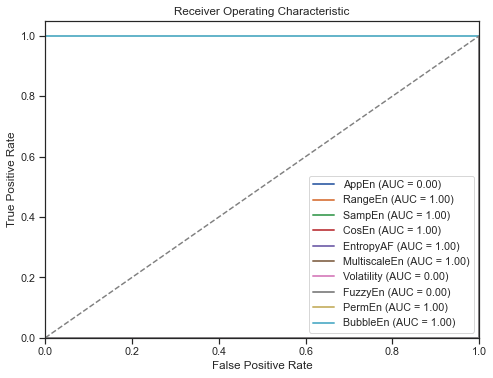

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Replace this with the actual DataFrame you have
export_df = pd.DataFrame({
    'Feature': ['AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn', 'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility'],
    'Mean Acc.': [0.882025, 0.879405, 0.879405, 0.880318, 0.771909, 0.863567, 0.631511, 0.616064, 0.855645, 0.780561],
    'SD of Acc.': [0.159679, 0.160325, 0.160325, 0.098054, 0.119450, 0.141360, 0.113435, 0.105295, 0.162571, 0.203759],
    'Total Acc.': [0.870619, 0.869952, 0.869952, 0.879803, 0.772594, 0.864793, 0.637765, 0.618484, 0.847536, 0.779732],
    'Sensitivity': [0.864129, 0.891125, 0.891125, 0.903782, 0.826502, 0.913572, 0.606329, 0.550260, 0.856564, 0.915797],
    'Specificity': [0.875925, 0.852645, 0.852645, 0.860203, 0.728529, 0.824920, 0.663460, 0.674251, 0.840157, 0.668512],
    'Precision': [0.850586, 0.831741, 0.831741, 0.840878, 0.713353, 0.810075, 0.595580, 0.579968, 0.814136, 0.693085],
    'f1': [0.857304, 0.860410, 0.860410, 0.871196, 0.765770, 0.858716, 0.600907, 0.564723, 0.834811, 0.789026]
})

# Sort the DataFrame based on the mean accuracy (optional)
export_df.sort_values(by='Mean Acc.', ascending=False, inplace=True)

plt.figure(figsize=(8, 6))
for i, feature in enumerate(export_df['Feature']):
    fpr, tpr, _ = roc_curve([1, 0], [export_df['Sensitivity'][i], export_df['Specificity'][i]])  # Example data for Sensitivity and Specificity
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(feature, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [12]:
    
export_df = pd.DataFrame(dataScores,columns=['Mean Acc.', 'SD of Acc.', 'Total Acc.', 'Sensitivity', 
                                             'Specificity','Precision','f1'])

export_df = export_df.set_index(pd.Index(['AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility']))

In [16]:
export_df

,Mean Acc.,SD of Acc.,Total Acc.,Sensitivity,Specificity,Precision,f1
AppEn,0.882025,0.159679,0.870619,0.864129,0.875925,0.850586,0.857304
SampEn,0.879405,0.160325,0.869952,0.891125,0.852645,0.831741,0.860410
CosEn,0.879405,0.160325,0.869952,0.891125,0.852645,0.831741,0.860410
RangeEn,0.880318,0.098054,0.879803,0.903782,0.860203,0.840878,0.871196
FuzzyEn,0.771909,0.119450,0.772594,0.826502,0.728529,0.713353,0.765770
EntropyAF,0.863567,0.141360,0.864793,0.913572,0.824920,0.810075,0.858716
PermEn,0.631511,0.113435,0.637765,0.606329,0.663460,0.595580,0.600907
BubbleEn,0.616064,0.105295,0.618484,0.550260,0.674251,0.579968,0.564723
MultiscaleEn,0.855645,0.162571,0.847536,0.856564,0.840157,0.814136,0.834811
Volatility,0.780561,0.203759,0.779732,0.915797,0.668512,0.693085,0.789026


In [17]:
export_df_highlight = export_df.copy()

export_df_highlight.style.highlight_max(color = 'lightgreen', axis = 0)

,Mean Acc.,SD of Acc.,Total Acc.,Sensitivity,Specificity,Precision,f1
AppEn,0.882025,0.159679,0.870619,0.864129,0.875925,0.850586,0.857304
SampEn,0.879405,0.160325,0.869952,0.891125,0.852645,0.831741,0.860410
CosEn,0.879405,0.160325,0.869952,0.891125,0.852645,0.831741,0.860410
RangeEn,0.880318,0.098054,0.879803,0.903782,0.860203,0.840878,0.871196
FuzzyEn,0.771909,0.119450,0.772594,0.826502,0.728529,0.713353,0.765770
EntropyAF,0.863567,0.141360,0.864793,0.913572,0.824920,0.810075,0.858716
PermEn,0.631511,0.113435,0.637765,0.606329,0.663460,0.595580,0.600907
BubbleEn,0.616064,0.105295,0.618484,0.550260,0.674251,0.579968,0.564723
MultiscaleEn,0.855645,0.162571,0.847536,0.856564,0.840157,0.814136,0.834811
Volatility,0.780561,0.203759,0.779732,0.915797,0.668512,0.693085,0.789026


In [18]:
export_df_highlight.style.highlight_min(color = 'lightcoral', axis = 0)

,Mean Acc.,SD of Acc.,Total Acc.,Sensitivity,Specificity,Precision,f1
AppEn,0.882025,0.159679,0.870619,0.864129,0.875925,0.850586,0.857304
SampEn,0.879405,0.160325,0.869952,0.891125,0.852645,0.831741,0.860410
CosEn,0.879405,0.160325,0.869952,0.891125,0.852645,0.831741,0.860410
RangeEn,0.880318,0.098054,0.879803,0.903782,0.860203,0.840878,0.871196
FuzzyEn,0.771909,0.119450,0.772594,0.826502,0.728529,0.713353,0.765770
EntropyAF,0.863567,0.141360,0.864793,0.913572,0.824920,0.810075,0.858716
PermEn,0.631511,0.113435,0.637765,0.606329,0.663460,0.595580,0.600907
BubbleEn,0.616064,0.105295,0.618484,0.550260,0.674251,0.579968,0.564723
MultiscaleEn,0.855645,0.162571,0.847536,0.856564,0.840157,0.814136,0.834811
Volatility,0.780561,0.203759,0.779732,0.915797,0.668512,0.693085,0.789026


In [19]:
export_df.to_csv(f'new-individual-features/CatBoost.csv')

In [15]:
#Ignore Stuff Below

In [16]:
#Ignore Stuff Below

In [17]:
#Ignore Stuff Below

In [18]:
#Ignore Stuff Below

In [19]:
#Ignore Stuff Below

In [20]:
#Ignore Stuff Below